# Проект: "Предсказание температуры плавки стали"

Чтобы оптимизировать производственные расходы, металлургический комбинат  решил уменьшить потребление электроэнергии на этапе обработки стали. 

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## 0. Введение

Цель работы - подготовка модели для прогнозирования оптимальной температуры плавки стали и подготовка отчета о выполненной работе и подборе модели. Метрика качества MAE, на тестовой выборке не более 7.6, предпочтительная не более 6.

Целевой признак - температрура из последнего замера партии, перед отправкой на доводку или машину непрерывной разливки.

Ход работы:
* Обзор и проверка данных
* Предобраюотка данных
* Подготовка данных
* Обучение моделей
* Тестирование лучшей содели
* Отчет по результатам


## 1. Обзор и проверка данных

Импортируем требуемые на данном этапе библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt
import scipy.stats as st
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import os

import lightgbm as lgb
import catboost as cb

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor


from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler 

import warnings
warnings.filterwarnings('ignore')

### 1.1 Данные об электродах:

Загрузим данные об электродах:

In [2]:
pth1 = '/datasets/final_steel/data_arc.csv'
pth2 = 'datasets/final_steel/data_arc.csv'
if os.path.exists(pth1):
    df_arc = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df_arc = pd.read_csv(pth2)
else:
    print("Проверьте правильность пути к датасету")

In [3]:
df_arc.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.5 MB


В таблице 4 столбца и 14876 строк, нулевые значения (или пропущенные)отсуствуют. Типы данных:  2 столбца с вещественными значениями типа float64, 2 столбеца со строковым типом object (поазывают дату и время, заменить тип), 1 столбец с целочисленым типом int64 . Используемый объем памяти 2.5 MB.

Описание параметров:


* `key` - номер партии;
* `Начало нагрева дугой` - время и дата начала нагрева;
* `Конец нагрева дугой` - время и дата окончания нагрева;
* `Активная мощность` - активная мощность потребления электроэнергии (в чем измеряется, в МВт?);
* `Реактивная мощность`- реактивная мощность потребления электроэнергии.

Рассмотрим данные:

In [4]:
df_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [5]:
df_arc[['Активная мощность','Реактивная мощность']].describe()

,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000
mean,0.670441,0.452592
std,0.408159,5.878702
min,0.030002,-715.504924
25%,0.395297,0.290991
50%,0.555517,0.415962
75%,0.857034,0.637371
max,3.731596,2.676388


При выводе основных статистик по столбцам `Активная мощность` и `Реактивная мощность` можно отметить аномальное  отрицательное значение по реактивной мощности, что возможно говорит о возможном сбое измерительного оборудования. Учитывая, что значения Активной мощности лежат в допустимых пределах) рекомендуется удалить эту строку, либо заменить значение. Также можно оставить данные не изменными, учитывая что значение реактивной мощности в перспективе не планируется к использованию в модели. 

Рассмотрим диаграммы распределения и размаха:

Text(0.5, 1.005, 'Диаграмма распределения и размаха Активная мощность')

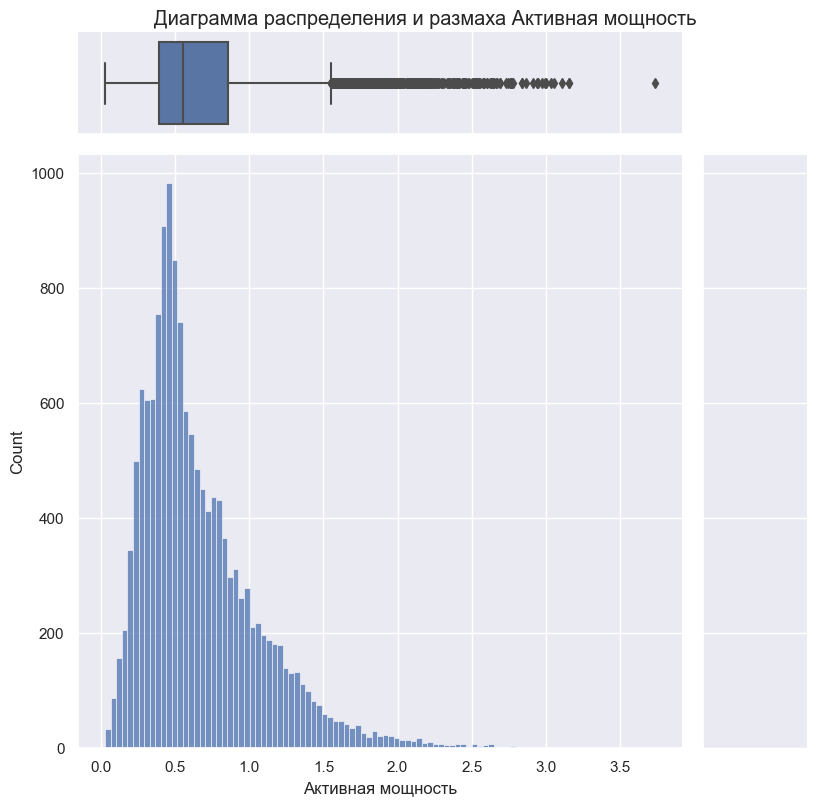

In [6]:
sns.set_theme(style="darkgrid")
g = sns.JointGrid(data=df_arc, x="Активная мощность", height=8)
g.plot_joint(sns.histplot)
g.plot_marginals(sns.boxplot)

plt.suptitle('Диаграмма распределения и размаха Активная мощность', x=0.5, y=1.005, ha='center', fontsize='large')

Text(0.5, 1.005, 'Диаграмма распределения и размаха Реактивная мощность')

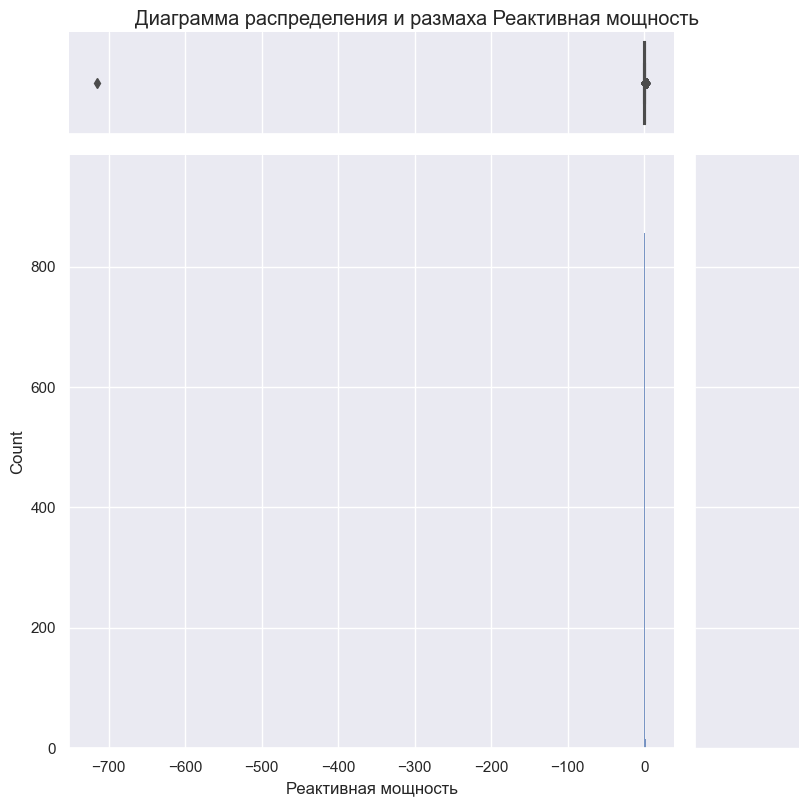

In [7]:
g = sns.JointGrid(data=df_arc, x="Реактивная мощность", height=8)
g.plot_joint(sns.histplot)
g.plot_marginals(sns.boxplot)

plt.suptitle('Диаграмма распределения и размаха Реактивная мощность', x=0.5, y=1.005, ha='center', fontsize='large')

Данные обоих величин распределены нормально, со скошенностью влево, что говорит об отставании медианного значения от среднего, что в целом выглядет логично, учитывая большое значение " выбросов" выше верхней границы диаграммы размаха. Медина значения Активной мощности составляет 0.55 (предположительно МВт), значчение Реактивно мощности составляет 0.41. 

Проверим аномалии в столбце `key`:

In [8]:
df_arc['key'].describe()

count    14876.000000
mean      1615.220422
std        934.571502
min          1.000000
25%        806.000000
50%       1617.000000
75%       2429.000000
max       3241.000000
Name: key, dtype: float64

Аномалий не обнаружено.

Рассчитаем столбец полной мощностью и посмотрим на ее распределение:

In [9]:
df_arc['Полная мощность'] = ((df_arc['Активная мощность'])**2 + (df_arc['Реактивная мощность'])**2)**0.5

In [10]:
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239


Text(0.5, 1.005, 'Диаграмма распределения и размаха Полная мощность')

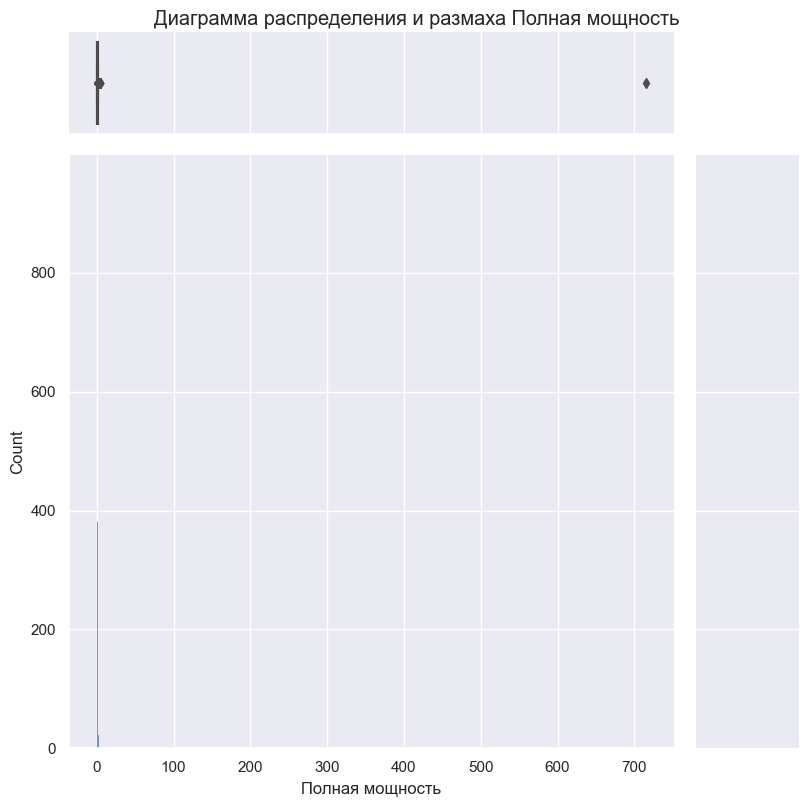

In [11]:
g = sns.JointGrid(data=df_arc, x="Полная мощность", height=8)
g.plot_joint(sns.histplot)
g.plot_marginals(sns.boxplot)

plt.suptitle('Диаграмма распределения и размаха Полная мощность', x=0.5, y=1.005, ha='center', fontsize='large')

Распределениние и статститики сопадают с характером величин активно и реактивной мощности, что логично. Также очевиден аномальный выброс в 715 МВА , за счет аномального значения Реактивной мощности.

Расчитаем и добавим в таблицу значение времени нагрева и выразим его в секндах:

In [12]:
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'])
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'])

In [13]:
df_arc['Время нагрева'] = (df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']).dt.total_seconds()

In [14]:
df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148.0
...,...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,0.640648,157.0
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,0.855559,180.0
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,0.874560,184.0
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0.264489,57.0


Построим график измененя суммарного времени нагрева по партиям:

Text(0.5, 1.005, 'Диаграмма распределения и размаха Времени нагрева по партиям')

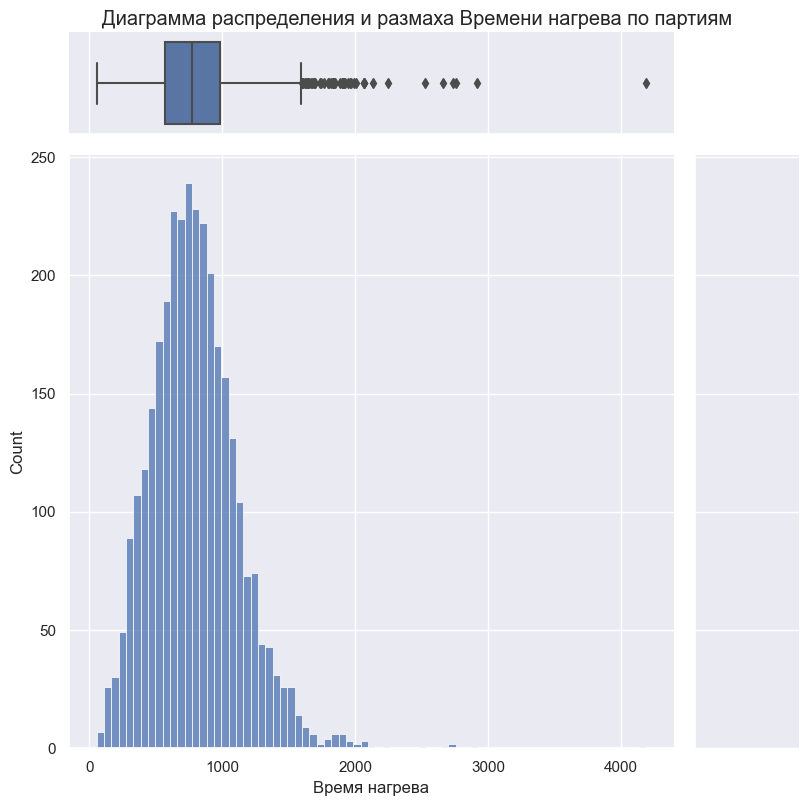

In [15]:
g = sns.JointGrid(data=df_arc.groupby('key').sum(), x="Время нагрева", height=8)
g.plot_joint(sns.histplot)
g.plot_marginals(sns.boxplot)

plt.suptitle('Диаграмма распределения и размаха Времени нагрева по партиям', x=0.5, y=1.005, ha='center', fontsize='large')

Отметим, что у ряда партий суммарное время нагрева более 2000 с. Построим график распределения числа циклов нагрева по партиям:

Text(0.5, 0.95, 'График распределения числа циклов нагрева по партиям')

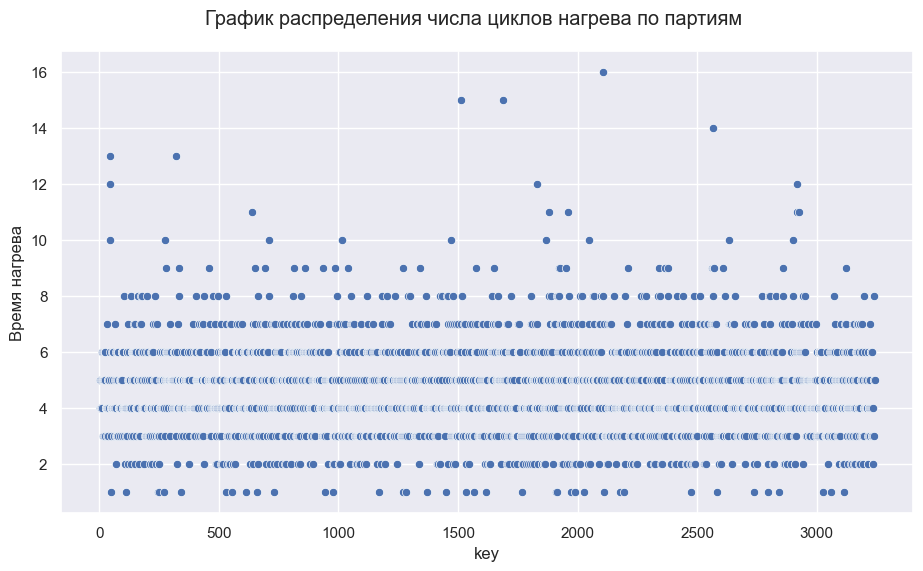

In [16]:
sns.set (rc={"figure.figsize":( 11 , 6 )})
sns.scatterplot(data=df_arc.groupby('key').count(), x='key', y='Время нагрева')
plt.suptitle('График распределения числа циклов нагрева по партиям', x=0.5, y=0.95, ha='center', fontsize='large')

Отметим, что для большинства партий требуется 3 - 6 циклов для достижения целевого хим. состава и температуры плавки. 

Рассмотрим статистики по средним показателям по каждой партии:

In [17]:
df_arc.groupby('key').mean().describe()

,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева
count,3214.000000,3214.000000,3214.000000,3214.000000
mean,0.671071,0.445853,0.895216,172.339290
std,0.207486,3.163786,3.157901,45.606667
min,0.186226,-178.647909,0.228541,57.000000
25%,0.519691,0.387213,0.651909,140.000000
50%,0.646633,0.489478,0.816520,168.750000
75%,0.797201,0.599788,0.996846,200.383333
max,1.819169,1.141721,179.284396,380.000000


Среднее время цикла нагрева 172 секунды (~3 минуты), при средней активной мощности 0.67 МВт. 

In [18]:
df_arc.groupby('key').sum().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Активная мощность    3214 non-null   float64
 1   Реактивная мощность  3214 non-null   float64
 2   Полная мощность      3214 non-null   float64
 3   Время нагрева        3214 non-null   float64
dtypes: float64(4)
memory usage: 125.5 KB


Суммарное число партий в данной таблице 3214, при условии что нумерация партий за рассматриваемый период 3241, что говорит о том что нумерация партий прерывается, или имеются пропуски значений в датасете по определнным партиям, что требуется учесть в предобработке данных.

### Свод по датасету:

* В таблице 4 столбца и 14876 строк, нулевые значения (или пропущенные)отсуствуют. Типы данных:  2 столбца с вещественными значениями типа float64, 2 столбеца со строковым типом object (поазывают дату и время, заменить тип), 1 столбец с целочисленым типом int64 . Используемый объем памяти 2.5 MB.

* При выводе основных статистик по столбцам `Активная мощность` и `Реактивная мощность` можно отметить аномальное  отрицательное значение по реактивной мощности, что возможно говорит о возможном сбое измерительного оборудования. 

* Данные обоих величин распределены нормально, со скошенностью влево, что говорит об отставании медианного значения от среднего, что в целом выглядет логично, учитывая большое значение " выбросов" выше верхней границы диаграммы размаха. Медина значения Активной мощности составляет 0.55 (предположительно МВт), значчение Реактивно мощности составляет 0.41. 

* Для ряда партий суммарное время нагрева более 2000 с.

* Для большинства партий требуется 3 - 6 циклов для достижения целевого хим. состава и температуры плавки. 

* Среднее время цикла нагрева 172 секунды (~3 минуты), при средней активной мощности 0.67 МВт.

* Суммарное число партий в данной таблице 3214, при условии что нумерация партий за рассматриваемый период 3241, что говорит о том что нумерация партий прерывается, или имеются пропуски значений в датасете по определнным партиям, что требуется учесть в предобработке данных.

###  1.2 Данные о подаче сыпучих материалов (объём):

Загрузим данные:

In [19]:
pth1 = '/datasets/final_steel/data_bulk.csv'
pth2 = 'datasets/final_steel/data_bulk.csv'
if os.path.exists(pth1):
    df_bulk = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df_bulk = pd.read_csv(pth2)
else:
    print("Проверьте правильность пути к датасету")

In [20]:
df_bulk.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


В таблице 16 столбцов и 3129 строк, пропущенные значения присуствуют и для большинства столбцов являются превалирующими.  Типы данных:  14 столбцов с вещественными значениями типа float64, 1 столбец с целочисленым типом int64 . Используемый объем памяти 391.2 KB.

Описание параметров:


* `key` - номер партии;
* `Bulk 1 ... 15` - объем типа (№1 - №15) сыпучей присадки, поданной в партию.

Рассмотрим данные:

In [21]:
df_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


С учетом описания технологического процесса, можно предположить, что пропущенное значение означает, что присадка в партию не падавалась. На основании этого, заменим пропущенные значения на нулевые:

In [22]:
df_bulk = df_bulk.fillna(0)

In [23]:
df_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


Построим диаграмму сравнения суммарного объема сыпучей присадки в зависимости от типа:

Text(0.5, 0.95, 'Диаграмма сравнения объемов сыпучей присадки по типу')

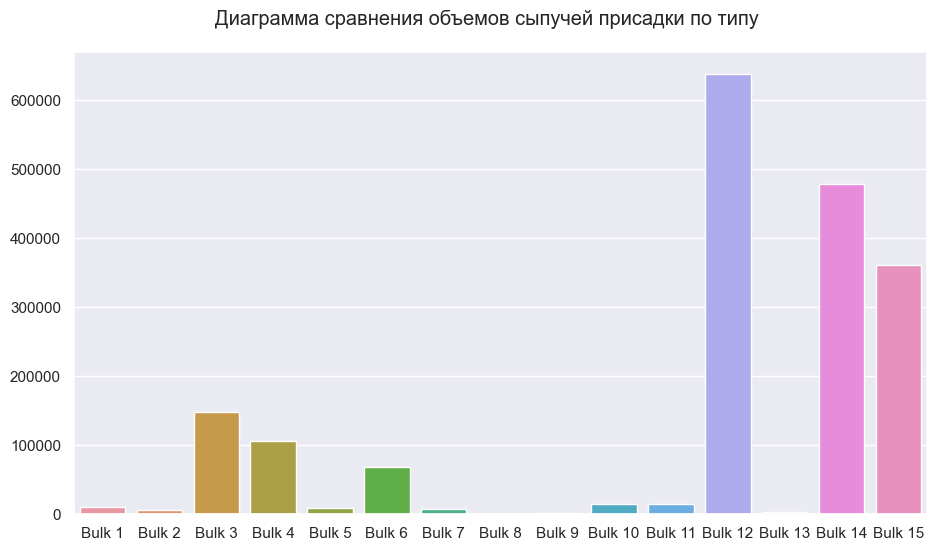

In [24]:
sns.barplot(data=df_bulk.drop(['key'], axis=1), estimator='sum', errorbar=None)
plt.suptitle('Диаграмма сравнения объемов сыпучей присадки по типу', x=0.5, y=0.95, ha='center', fontsize='large')

In [25]:
df_bulk.drop(['key'], axis=1).sum().sort_values(ascending=False)

Bulk 12    638154.0
Bulk 14    477819.0
Bulk 15    360834.0
Bulk 3     147815.0
Bulk 4     105856.0
Bulk 6      68501.0
Bulk 10     14658.0
Bulk 11     13597.0
Bulk 1       9889.0
Bulk 5       8241.0
Bulk 7       7640.0
Bulk 2       5567.0
Bulk 13      3260.0
Bulk 9       1450.0
Bulk 8         49.0
dtype: float64

Наибольший объем супучей присадки, используемой в процессе, является присадка типа `Bulk12`(638154) , далее `Bulk 14` и `Bulk 15`, наименьший объем у присадки `Bulk 8`(49). Посмотрим, сравнение типа присадок по частоте их использования:

Text(0.5, 0.95, 'Диаграмма частоты использования присадок')

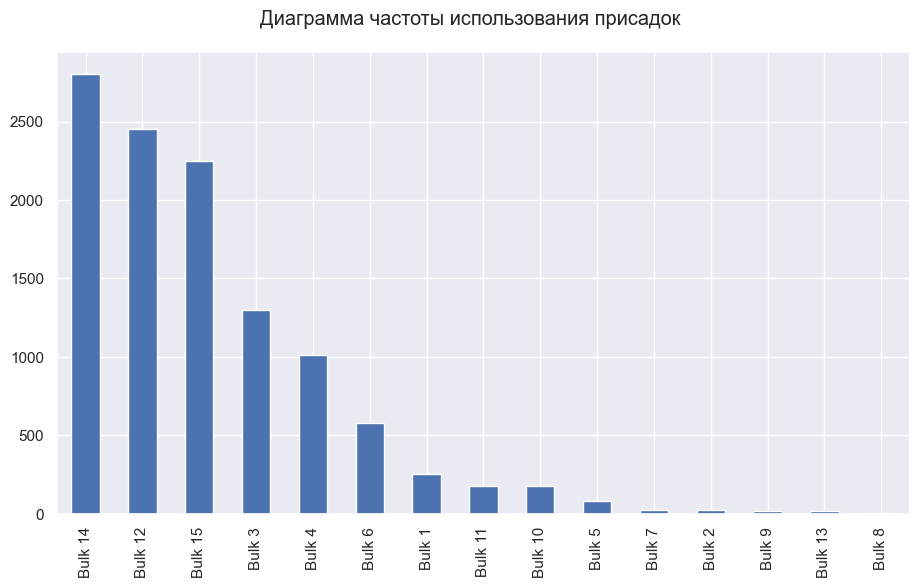

In [28]:
df_bulk[df_bulk != 0].count(axis=0).loc['Bulk 1':'Bulk 15'].sort_values(ascending=False).plot.bar()
plt.suptitle('Диаграмма частоты использования присадок', x=0.5, y=0.95, ha='center', fontsize='large')

In [27]:
df_bulk[df_bulk != 0].count(axis=0).loc['Bulk 1':'Bulk 15'].sort_values(ascending=False)

Bulk 14    2806
Bulk 12    2450
Bulk 15    2248
Bulk 3     1298
Bulk 4     1014
Bulk 6      576
Bulk 1      252
Bulk 11     177
Bulk 10     176
Bulk 5       77
Bulk 7       25
Bulk 2       22
Bulk 9       19
Bulk 13      18
Bulk 8        1
dtype: int64

Отметим, что несмотря на то, что присадка Bulk 12 имеет больший объем, но наиболее часто используемой присадкой является `Bulk 14` (2806 раза), а потом `Bulk 12` и `Bulk 15`. Реже всех используется присадка `Bulk 8`(1 раз). 

Добавим столбец с суммарным объемом всех присадок в партии:

In [37]:
df_bulk['sum'] = df_bulk.loc[:,'Bulk 1':'Bulk 15'].sum(axis=1)

In [38]:
df_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,758.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,594.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,630.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0,272.0


Построим распределения и статистики:

Text(0.5, 0.95, 'График распределения объема присадок по партиям')

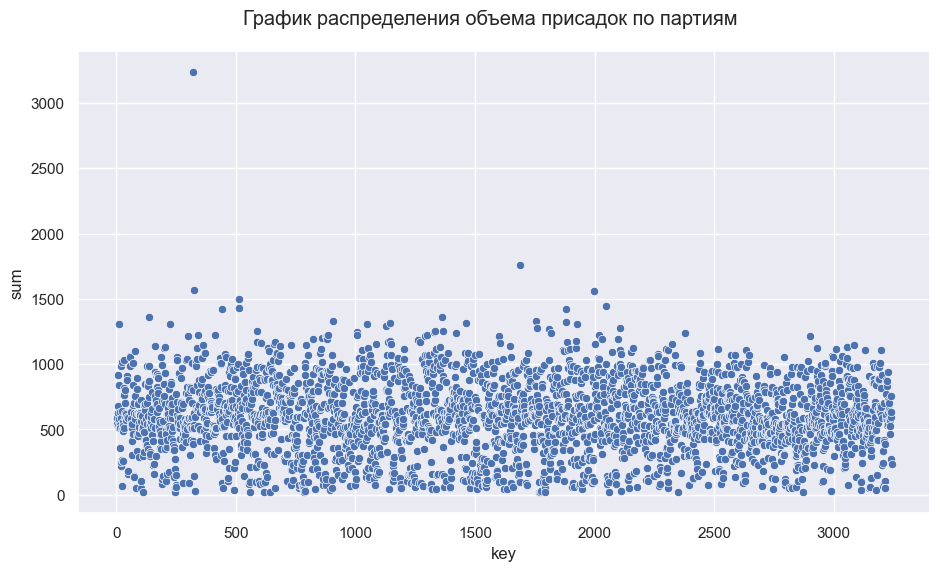

In [42]:
sns.scatterplot(data=df_bulk, x='key', y='sum')
plt.suptitle('График распределения объема присадок по партиям', x=0.5, y=0.95, ha='center', fontsize='large')

Text(0.5, 1.005, 'Диаграмма распределения и размаха объема присадок по партиям')

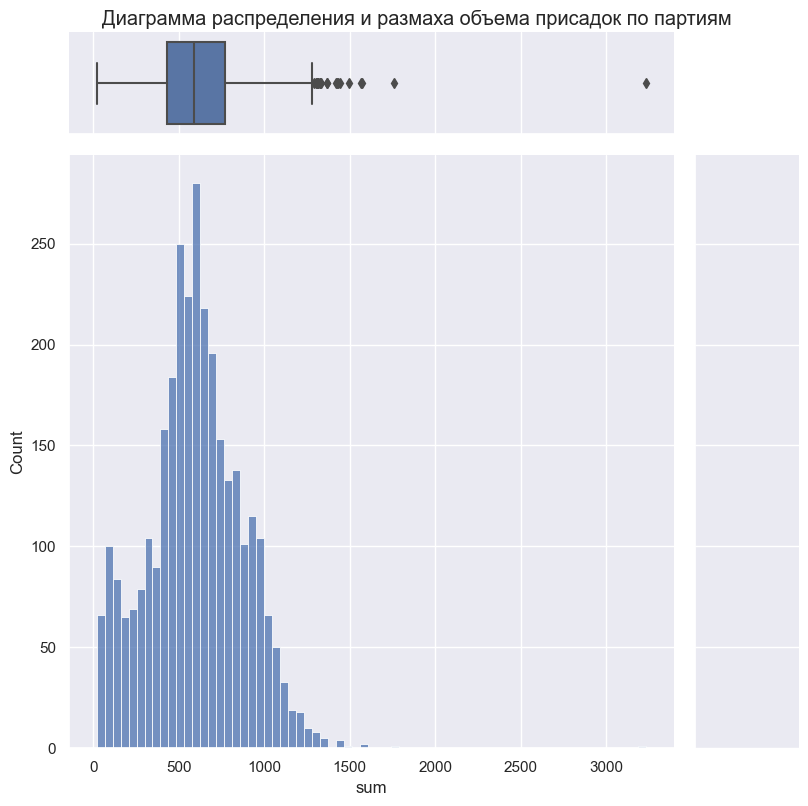

In [44]:
g = sns.JointGrid(data=df_bulk, x='sum', height=8)
g.plot_joint(sns.histplot)
g.plot_marginals(sns.boxplot)

plt.suptitle('Диаграмма распределения и размаха объема присадок по партиям', x=0.5, y=1.005, ha='center', fontsize='large')

In [59]:
df_bulk.drop(['key'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
Bulk 1,3129.0,3.160435,11.869164,0.0,0.0,0.0,0.0,185.0
Bulk 2,3129.0,1.779163,21.217878,0.0,0.0,0.0,0.0,325.0
Bulk 3,3129.0,47.240332,74.239954,0.0,0.0,0.0,80.0,454.0
Bulk 4,3129.0,33.830617,56.034505,0.0,0.0,0.0,68.0,281.0
Bulk 5,3129.0,2.633749,20.918138,0.0,0.0,0.0,0.0,603.0
Bulk 6,3129.0,21.892298,55.492582,0.0,0.0,0.0,0.0,503.0
Bulk 7,3129.0,2.441675,31.944063,0.0,0.0,0.0,0.0,772.0
Bulk 8,3129.0,0.015660,0.875978,0.0,0.0,0.0,0.0,49.0
Bulk 9,3129.0,0.463407,6.154398,0.0,0.0,0.0,0.0,147.0
Bulk 10,3129.0,4.684564,20.157323,0.0,0.0,0.0,0.0,159.0


Распределение суммарного объема присадок в партии носит нормальный характер с явным пиком 500 - 600, и локальным пиковым значением в интервале 50 - 150.

In [60]:
df_bulk['key'].count()

3129

### Свод по датасету:

* В таблице 16 столбцов и 3129 строк, пропущенные значения присуствуют и для большинства столбцов являются превалирующими.  Типы данных:  14 столбцов с вещественными значениями типа float64, 1 столбец с целочисленым типом int64 . Используемый объем памяти 391.2 KB.

* Заменены пропущенные значения на нулевые, т.к преположительно пропуски означают отсуствие подачи присадки.


* Наибольший объем супучей присадки, используемой в процессе, является присадка типа `Bulk12`(638154) , далее `Bulk 14` и `Bulk 15`, наименьший объем у присадки `Bulk 8`(49).

* Несмотря на то, что присадка `Bulk 12` имеет больший объем, но наиболее часто используемой присадкой является `Bulk 14` (2806 раза), а потом `Bulk 12` и `Bulk 15`. Реже всех используется присадка `Bulk 8`(1 раз). 

* Распределение суммарного объема присадок в партии носит нормальный характер с явным пиком 500 - 600, и локальным пиковым значением в интервале 50 - 150.

### 1.3 Данные о подаче сыпучих материалов (время):

Загрузим данные и рассмотрим информацию:

In [61]:
pth1 = '/datasets/final_steel/data_bulk_time.csv'
pth2 = 'datasets/final_steel/data_bulk_time.csv'
if os.path.exists(pth1):
    df_bulk_time = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df_bulk_time = pd.read_csv(pth2)
else:
    print("Проверьте правильность пути к датасету")

In [62]:
df_bulk_time.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 1.9 MB


В таблице 16 столбцов и 3129 строк, пропущенные значения присуствуют и для большинства столбцов являются превалирующими.  Типы данных:  15 столбцов со строковым значением типа object, 1 столбец с целочисленым типом int64 . Используемый объем памяти 1.9 MB.

Описание параметров:

* `key` - номер партии;
* `Bulk 1 ... 15` - время подачи типа (№1 - №15) сыпучей присадки в партию.

In [63]:
df_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


In [64]:
df_bulk_time = df_bulk_time.fillna(0)
df_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0,0,0,2019-05-03 11:21:30,0,0,0,0,0,0,0,2019-05-03 11:03:52,0,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,0,0,0,2019-05-03 11:46:38,0,0,0,0,0,0,0,2019-05-03 11:40:20,0,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,0,0,0,2019-05-03 12:31:06,0,0,0,0,0,0,0,2019-05-03 12:09:40,0,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,0,0,0,2019-05-03 12:48:43,0,0,0,0,0,0,0,2019-05-03 12:41:24,0,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,0,0,0,2019-05-03 13:18:50,0,0,0,0,0,0,0,2019-05-03 13:12:56,0,2019-05-03 13:12:56,2019-05-03 13:12:56


### 1.4 Данные о продувке сплава газом

Загрузим данные и рассмотрим информацию:

In [65]:
pth1 = '/datasets/final_steel/data_gas.csv'
pth2 = 'datasets/final_steel/data_gas.csv'
if os.path.exists(pth1):
    df_gas = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df_gas = pd.read_csv(pth2)
else:
    print("Проверьте правильность пути к датасету")

In [66]:
df_gas.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


В таблице 2 столбца и 3239 строк, пропущенные значения отуствуют.  Типы данных:  1 столбцец с вещественными значениями типа float64, 1 столбец с целочисленым типом int64 . Используемый объем памяти 50.7 KB.

Описание параметров:

* `key` - номер партии;
* `Газ 1` - объем газ для продувки сплава , поданной в партию.

In [67]:
df_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [68]:
df_gas['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

In [69]:
df_gas['key'].nunique()

3239

Число знвачений партий составляет 3239, что превышает значение в ранее рассмотренных датасетах, соотвественно в таблице имеются данные по объему газа для партий, по которым отсуствует информация.

Построим распределения по датасету:

Text(0.5, 0.95, 'Диаграмма распределения объемов продувки сплава газом по партиям')

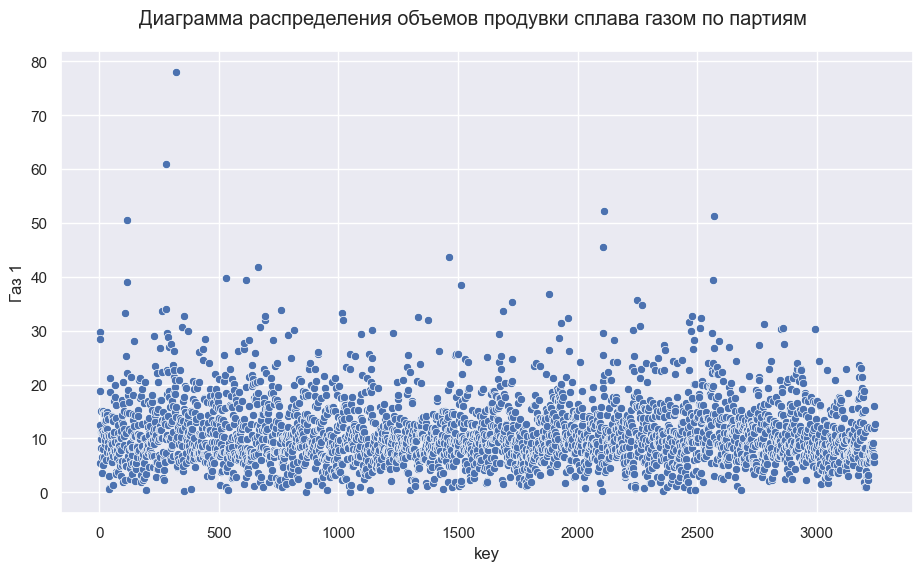

In [70]:
sns.scatterplot(data=df_gas,  x='key', y='Газ 1')
plt.suptitle('Диаграмма распределения объемов продувки сплава газом по партиям', 
             x=0.5, y=0.95, ha='center', fontsize='large')

Text(0.5, 1.005, 'Диаграмма распределения и размаха объема продувки сплава газом присадок по партиям')

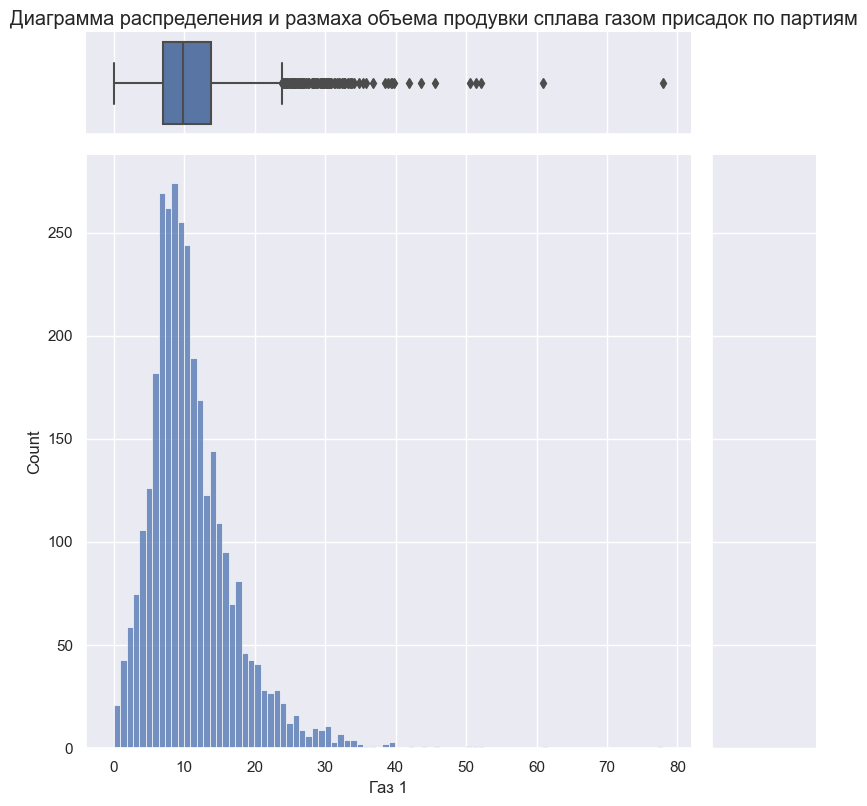

In [71]:
g = sns.JointGrid(data=df_gas, x='Газ 1', height=8)
g.plot_joint(sns.histplot)
g.plot_marginals(sns.boxplot)

plt.suptitle('Диаграмма распределения и размаха объема продувки сплава газом присадок по партиям',
             x=0.5, y=1.005, ha='center', fontsize='large')

Данные по объему газа распределены равномерно со скошенностью влево, что говорит о том что медиана (9.83) догоняет среднее значение (~11), что вызвано наличием определнным экстремальных значений выше верхней границы диаграммы размаха, например имеются партии (key 322),  где значение объема газа составляет 77.9.

### Свод по датасету:

* В таблице 2 столбца и 3239 строк, пропущенные значения отуствуют.  Типы данных:  1 столбцец с вещественными значениями типа float64, 1 столбец с целочисленым типом int64 . Используемый объем памяти 50.7 KB.

* Число знвачений партий составляет 3239, что превышает значение в ранее рассмотренных датасетах, соотвественно в таблице имеются данные по объему газа для партий, по которым отсуствует информация.

* Данные по объему газа распределены равномерно со скошенностью влево, что говорит о том что медиана (9.83) догоняет среднее значение (~11), что вызвано наличием определнным экстремальных значений выше верхней границы диаграммы размаха, например имеются партии (key 322),  где значение объема газа составляет 77.9.

### 1.5 Результаты измерения температуры

Загрузим данные и рассмотрим информацию:

In [72]:
pth1 = '/datasets/final_steel/data_temp.csv'
pth2 = 'datasets/final_steel/data_temp.csv'
if os.path.exists(pth1):
    df_temp = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df_temp = pd.read_csv(pth2)
else:
    print("Проверьте правильность пути к датасету")

In [73]:
df_temp.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.4 MB


В таблице 3 столбца и 15907 строк, имеются пропущенные значения в столбце `Температура`.  Типы данных:  1 столбцец с вещественными значениями типа float64, 1 столбец с целочисленым типом int64 И один столбец со строковым типом данных. Используемый объем памяти 1.4 MB.

Описание параметров:

* `key` - номер партии;
* `Время замера` - информация о времени замера температуры;
* `Температура` - температура сплава по данным замера.

In [74]:
df_temp.tail(10)

,key,Время замера,Температура
15897,3240,2019-09-01 03:12:19,NaN
15898,3240,2019-09-01 03:19:09,NaN
15899,3240,2019-09-01 03:31:27,NaN
15900,3240,2019-09-01 03:34:31,NaN
15901,3240,2019-09-01 03:35:16,NaN
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


При рассмотрении конца датасета наблюдаются пропуски данных, однако значение начальной температуры присуствуют. Т.к. отсуствует значение целевого признака, то такие партии целесообразнее удалить.

In [75]:
df_temp.isna().sum()

key                0
Время замера       0
Температура     2901
dtype: int64

Число пропущенных значений по температуре составляет 2901 шт, что составляет ~18 % данных по столбцу.

Выедем строки с наличием пропущенных значений:

In [76]:
df_temp[df_temp['Температура'].isna()]

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


Пропуски начинаются с партии 2500 и до конца датасета.

Визуализируем распределение данных по партиям и получим статситики:

Text(0.5, 0.95, 'Диаграмма распределения Температуры по партиям')

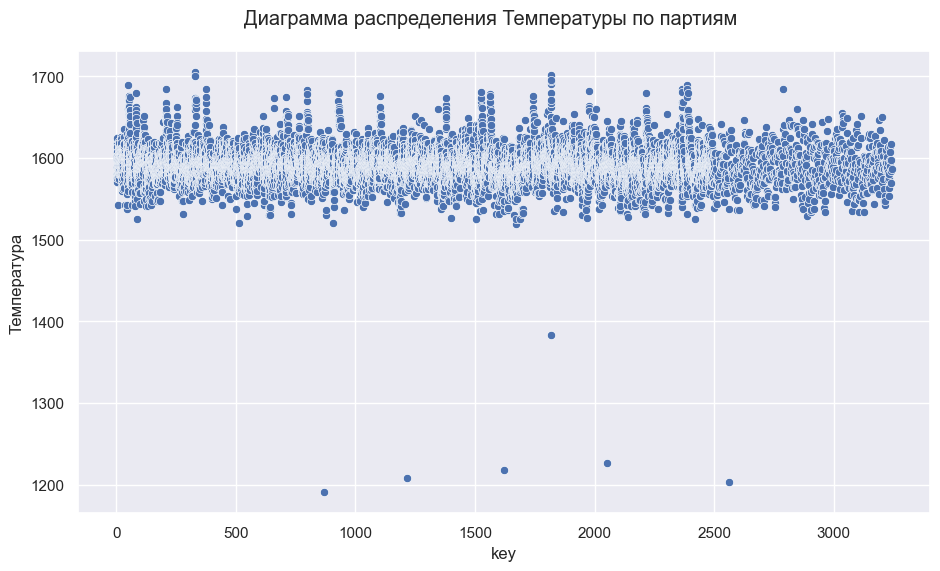

In [77]:
sns.scatterplot(data=df_temp,  x='key', y='Температура')
plt.suptitle('Диаграмма распределения Температуры по партиям', x=0.5, y=0.95, ha='center', fontsize='large')

In [78]:
df_temp['Температура'].describe()

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

Text(0.5, 1.005, 'Диаграмма распределения и размаха Температуры')

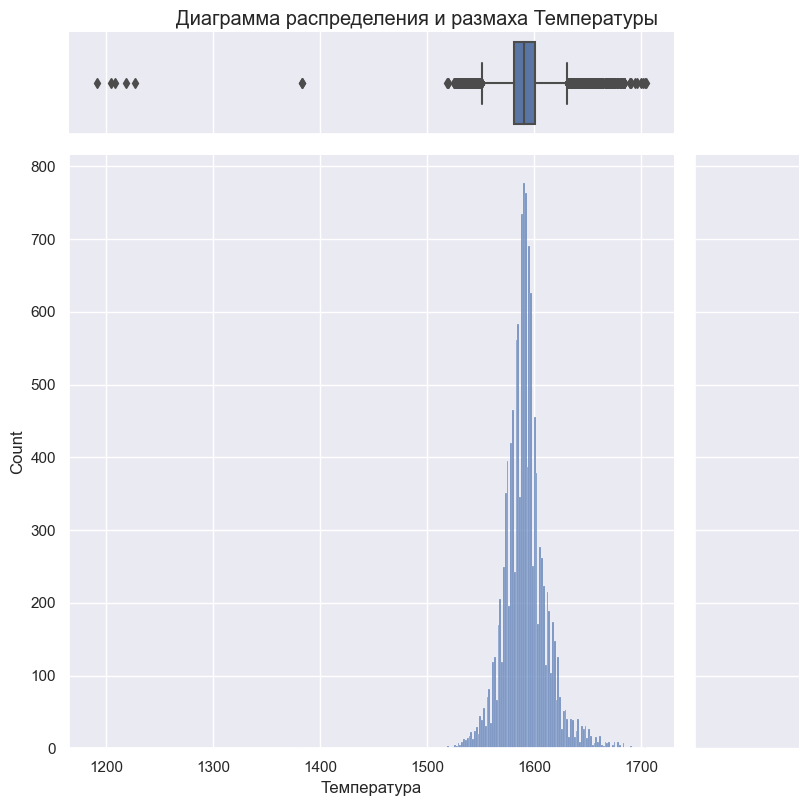

In [79]:
g = sns.JointGrid(data=df_temp, x='Температура', height=8)
g.plot_joint(sns.histplot)
g.plot_marginals(sns.boxplot)

plt.suptitle('Диаграмма распределения и размаха Температуры', x=0.5, y=1.005, ha='center', fontsize='large')

Распределение температуры носит нормальный характер с мединой в значении 1591 градус Цельсия. В данных имется аномальные значения, которые лежат ниже наименьшей границы температуры плавления стали (1300 гр.), что говорит о сбое или некоректности данных. Партии с учетом этих данных необходимо удалить.

Предварительно выведем таблицу с целевым признаком оптимальной температуры(данные в дальнейшем должны пройти преобработку исключив утечку целевого признака, удалив аномальные значения):

In [80]:
df_temp_pivot = df_temp.pivot_table(index = 'key',values = 'Температура', aggfunc = 'last')

In [81]:
df_temp_pivot

,Температура
key,
1,1613.0
2,1602.0
3,1599.0
4,1625.0
5,1602.0
...,...
3237,1569.0
3238,1584.0
3239,1598.0


In [82]:
df_temp_pivot.describe()

,Температура
count,3216.000000
mean,1593.928483
std,19.874627
min,1204.000000
25%,1585.000000
50%,1593.000000
75%,1600.000000
max,1700.000000


Отметим, что число партий сосавило 3216 шт, что также отличается от значений в предыдущих датасетах ( и будет еще меньше после этапа предобработки).

### Свод по датасету:

* В таблице 3 столбца и 15907 строк, имеются пропущенные значения в столбце `Температура`.  Типы данных:  1 столбцец с вещественными значениями типа float64, 1 столбец с целочисленым типом int64 И один столбец со строковым типом данных. Используемый объем памяти 1.4 MB.

* При рассмотрении конца датасета наблюдаются пропуски данных, однако значение начальной температуры присуствуют. Т.к. отсуствует значение целевого признака, то такие партии целесообразнее удалить.

* Число пропущенных значений по температуре составляет 2901 шт, что составляет ~18 % данных по столбцу. Пропуски начинаются с партии 2500 и до конца датасета.

* Распределение температуры носит нормальный характер с мединой в значении 1591 градус Цельсия. В данных имется аномальные значения, которые лежат ниже наименьшей границы температуры плавления стали (1300 гр.), что говорит о сбое или некоректности данных. Партии с учетом этих данных необходимо удалить.

### 1.6 Данные о проволочных материалах (объём)

Загрузим данные и рассмотрим информацию:

In [83]:
pth1 = '/datasets/final_steel/data_wire.csv'
pth2 = 'datasets/final_steel/data_wire.csv'
if os.path.exists(pth1):
    df_wire = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df_wire = pd.read_csv(pth2)
else:
    print("Проверьте правильность пути к датасету")

In [84]:
df_wire.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


В таблице 10 столбцов и 3081 строк, пропущенные значения присуствуют и для большинства столбцов являются превалирующими.  Типы данных:  9 столбцов с вещественными значениями типа float64, 1 столбец с целочисленым типом int64 . Используемый объем памяти 240.8 KB.

Описание параметров:

* `key` - номер партии;
* `Wire 1 ... 9` - объем типа (№1 - №9) проволочной присадки, поданной в партию.

In [85]:
df_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Заменим пропущенные значения на нули, т.к предположительно пропуски возникли вследствии отсуствия факта подачи проводки в интервал времени.

In [86]:
df_wire = df_wire.fillna(0)

In [87]:
df_wire 

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Построим диаграмму сравнения суммарного объема проволки в зависимости от типа:

Text(0.5, 0.95, 'Диаграмма сравнения объема типа проволки')

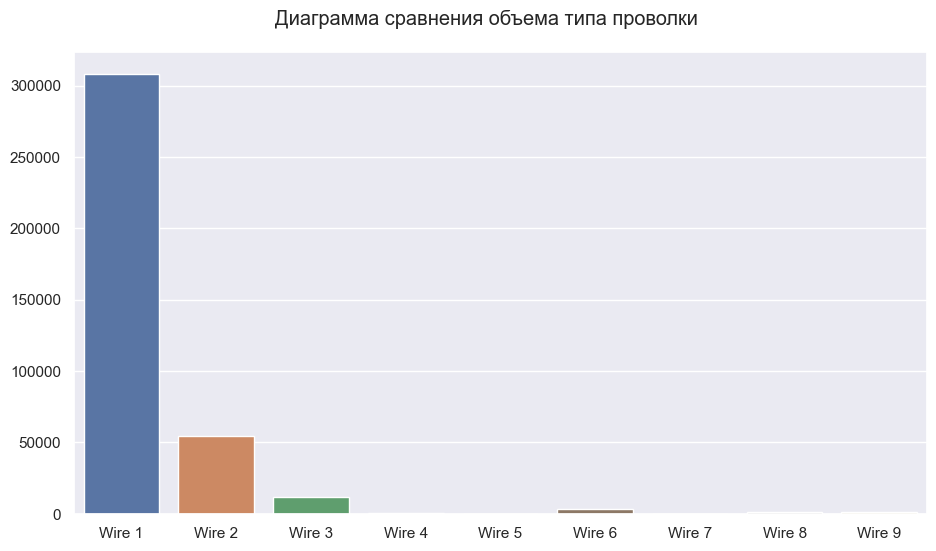

In [88]:
sns.barplot(data=df_wire.drop(['key'], axis=1), estimator='sum', errorbar=None)
plt.suptitle('Диаграмма сравнения объема типа проволки', x=0.5, y=0.95, ha='center', fontsize='large')

In [89]:
df_wire.drop(['key'], axis=1).sum().sort_values(ascending=False)

Wire 1    308236.830606
Wire 2     54572.931650
Wire 3     11937.408916
Wire 6      3505.239099
Wire 8      1018.878666
Wire 9       990.516814
Wire 4       804.199781
Wire 7       110.429080
Wire 5        15.132000
dtype: float64

Наибольший объем проволки, используемый в процессе, принадлежит типу `Wire 1` (308236.83), далее `Wire 2` и `Wire 3`. Наименьший объем у проволки типа `Wire 5`(15.1).
Посмотри на частоту использования проволки в процессе по типу:

Text(0.5, 0.95, 'Диаграмма частоты использования типа проволки')

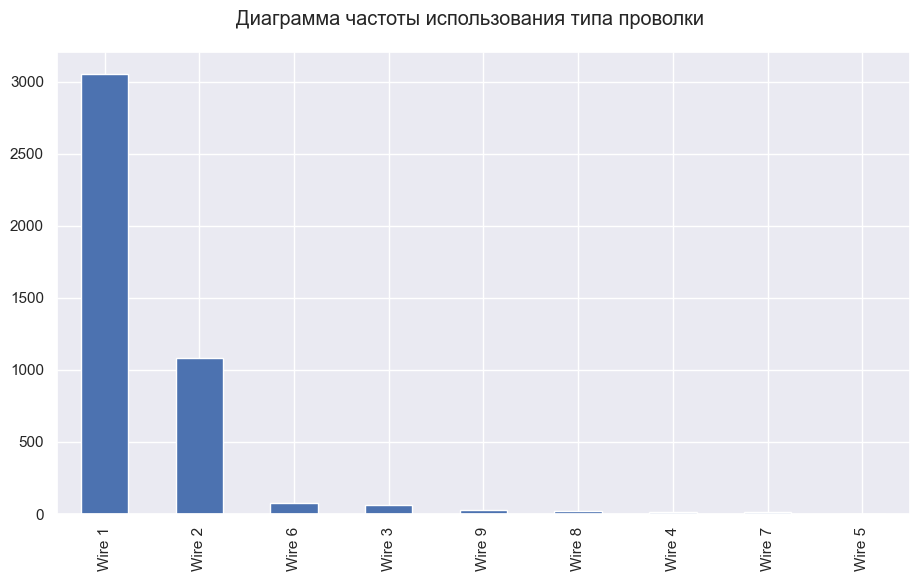

In [90]:
df_wire[df_wire != 0].count(axis=0).loc['Wire 1':'Wire 9'].sort_values(ascending=False).plot.bar()
plt.suptitle('Диаграмма частоты использования типа проволки', x=0.5, y=0.95, ha='center', fontsize='large')

In [91]:
df_wire[df_wire != 0].count(axis=0).loc['Wire 1':'Wire 9'].sort_values(ascending=False)

Wire 1    3055
Wire 2    1079
Wire 6      73
Wire 3      63
Wire 9      29
Wire 8      19
Wire 4      14
Wire 7      11
Wire 5       1
dtype: int64

Наиболее часто использумая проволка типа `Wire 1` (3055 раз), за ней идут `Wire 2`  и `Wire 6`. Меньше всех используется `Wire 5`(1 раз). 

Добавим столбец с суммарным обхемом проволки разных типов в партии:

In [92]:
df_wire['sum'] = df_wire.loc[:,'Wire 1':'Wire 9'].sum(axis=1)

In [93]:
df_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796
...,...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.088959
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.128799
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.357761
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.070400


Построим распределения и статистики:

Text(0.5, 0.95, 'График распределения объема проволки по партиям')

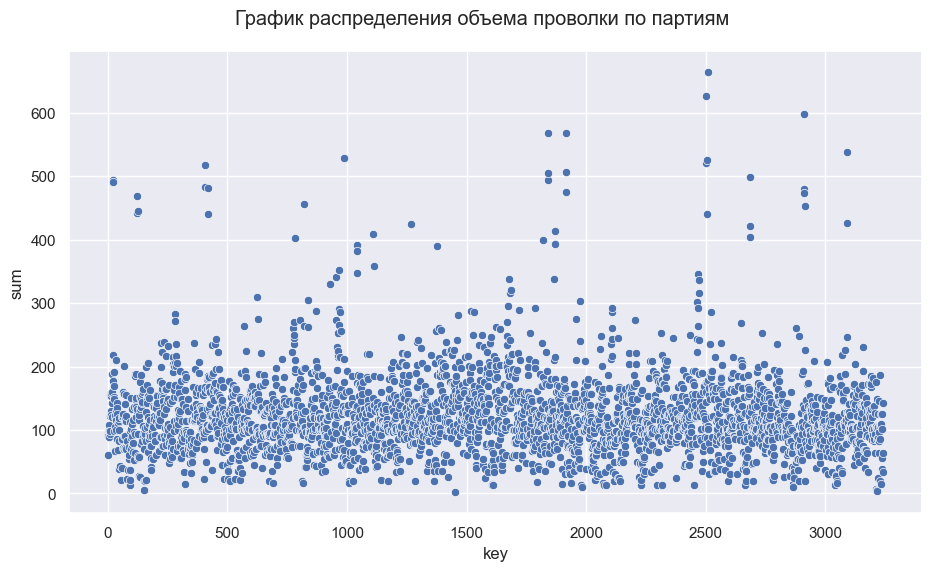

In [94]:
sns.scatterplot(data=df_wire, x='key', y='sum')
plt.suptitle('График распределения объема проволки по партиям', x=0.5, y=0.95, ha='center', fontsize='large')

Text(0.5, 1.005, 'Диаграмма распределения и размаха объема проволки по партиям')

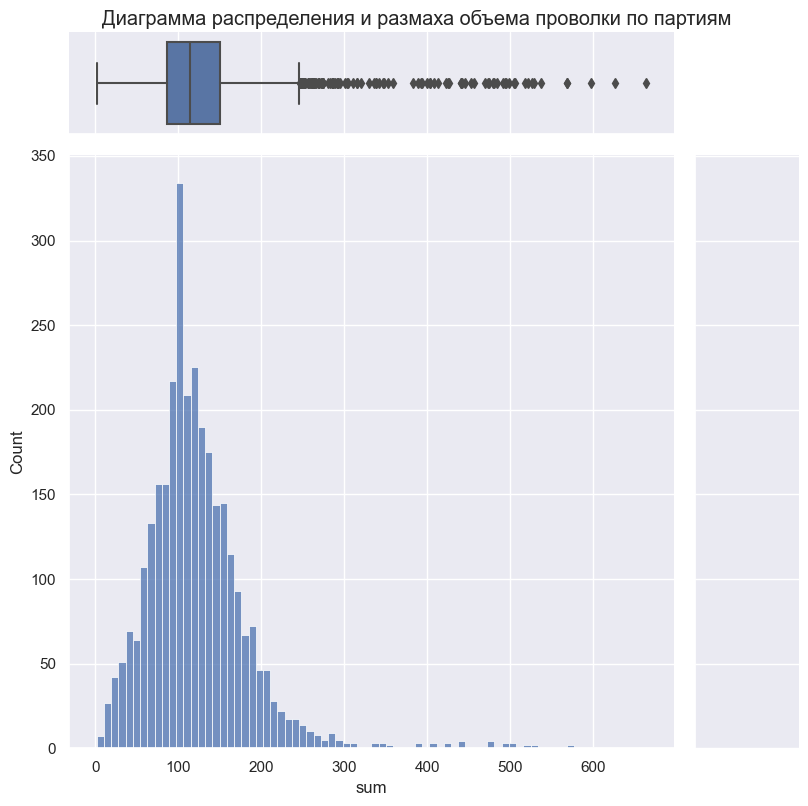

In [95]:
g = sns.JointGrid(data=df_wire, x='sum', height=8)
g.plot_joint(sns.histplot)
g.plot_marginals(sns.boxplot)

plt.suptitle('Диаграмма распределения и размаха объема проволки по партиям', x=0.5, y=1.005, ha='center', fontsize='large')

In [96]:
df_wire.drop(['key'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
Wire 1,3081.0,100.044411,42.841120,0.0000,70.28112,100.114563,125.798405,330.314424
Wire 2,3081.0,17.712733,33.517734,0.0000,0.00000,0.000000,23.162880,282.780152
Wire 3,3081.0,3.874524,30.310417,0.0000,0.00000,0.000000,0.000000,385.008668
Wire 4,3081.0,0.261019,4.293865,0.0000,0.00000,0.000000,0.000000,113.231044
Wire 5,3081.0,0.004911,0.272615,0.0000,0.00000,0.000000,0.000000,15.132000
Wire 6,3081.0,1.137695,8.958111,0.0000,0.00000,0.000000,0.000000,180.454575
Wire 7,3081.0,0.035842,0.774190,0.0000,0.00000,0.000000,0.000000,32.847674
Wire 8,3081.0,0.330697,4.392677,0.0000,0.00000,0.000000,0.000000,102.762401
Wire 9,3081.0,0.321492,3.806904,0.0000,0.00000,0.000000,0.000000,90.053604
sum,3081.0,123.723326,66.082966,1.9188,86.11200,114.179523,150.181198,663.851766


Распределение суммарного объема проволки в партии носит нормальный характер с явным пиком 100 - 110.

In [97]:
df_wire['key'].count()

3081

Отметим, что в данном датасете используется иное число партий, чем в предыдущих, что скорее всего свидетельствует о том, что присадка не применялась для части партий.

### Свод по датасету:

* В таблице 10 столбцов и 3081 строк, пропущенные значения присуствуют и для большинства столбцов являются превалирующими.  Типы данных:  9 столбцов с вещественными значениями типа float64, 1 столбец с целочисленым типом int64 . Используемый объем памяти 240.8 KB.

* Заменены пропущенные значения на нули, т.к предположительно пропуски возникли вследствии отсуствия факта подачи проводки в интервал времени.

* Наибольший объем проволки, используемый в процессе, принадлежит типу `Wire 1` (308236.83), далее `Wire 2` и `Wire 3`. Наименьший объем у проволки типа `Wire 5`(15.1).

* Наиболее часто использумая проволка типа `Wire 1` (3055 раз), за ней идут `Wire 2`  и `Wire 6`. Меньше всех используется `Wire 5`(1 раз). 

* Распределение суммарного объема проволки в партии носит нормальный характер с явным пиком 100 - 110.

### 1.7 Данные о проволочных материалах (время)

Загрузим данные и рассмотрим информацию:

In [98]:
pth1 = '/datasets/final_steel/data_wire_time.csv'
pth2 = 'datasets/final_steel/data_wire_time.csv'
if os.path.exists(pth1):
    df_wire_time = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df_wire_time = pd.read_csv(pth2)
else:
    print("Проверьте правильность пути к датасету")

In [99]:
df_wire_time.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 1.1 MB


В таблице 10 столбцов и 3081 строк, пропущенные значения присуствуют и для большинства столбцов являются превалирующими.  Типы данных:  9 столбцов со строковым типом данных object, 1 столбец с целочисленым типом int64 . Используемый объем памяти 1.1 MB.

Описание параметров:

* `key` - номер партии;
* `Wire 1 ... 9` - время подачи типа (№1 - №9) проволочной присадки в партию.

In [100]:
df_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
df_wire_time = df_wire_time.fillna(0)

In [102]:
df_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,0,0,0,0,0,0,0,0
1,2,2019-05-03 11:46:10,0,0,0,0,0,0,0,0
2,3,2019-05-03 12:13:47,0,0,0,0,0,0,0,0
3,4,2019-05-03 12:48:05,0,0,0,0,0,0,0,0
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,0,0,0,0,0,0,0,0
3077,3238,2019-08-31 23:38:24,0,0,0,0,0,0,0,0
3078,3239,2019-09-01 01:50:43,0,0,0,0,0,0,0,0
3079,3240,2019-09-01 03:12:02,0,0,0,0,0,0,0,0


### 1.8 Вывод

* Рассмотрено 7 датасетов с целью обзора и проверки данных;
* Выводы по каждому датасету предоставлены в графе Свод по датасету после каждого датасета;
* В разных датасетах имеются свои аномали или пропущенные значения. Анмальные значения рекативной мощности в датасете о времени и мощности нагрева, аномальные значения температуры в датасете о результатах измерения температуры, которые потребуется удалить. Также имеются пропуски по целевому признаку, данные также целесообразно удалить.
* Значения колличество и номеров партий отличаются в заивисмоти от датасета, что необходимо устранить на этапе предобработки данных.





## 2. Предобработка данных

### 2.1 Предобработка датасета об электродах

Выполним предобработку данных в соотвествии с намеченным планом.
Уберем аномальное значение реактивной мощности:

In [103]:
df_arc[df_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924,715.505096,109.0


In [104]:
df_arc[df_arc['key'] == 2116]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141,0.530511,122.0
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352,0.742616,135.0
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924,715.505096,109.0
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796,0.359361,67.0


Аномальное значение реактивной мощности является промежуточным. Удалим данную строку из датасета:

In [105]:
df_arc_clear = df_arc[df_arc['Реактивная мощность'] > 0]

### 2.2 Предобработка датасета по температуре

Предобработаем данные в датасете по температуре, заменим пропущенные значения на 0 значения, в дальнейшем создадим списко партий, где имеются значения температуры ниже порогового значения, таким образом уберем все партии где были пропущенные значения и аномальные значения температуры:

In [106]:
df_temp = df_temp.fillna(0) 

In [107]:
bad_temp_keys = df_temp[df_temp['Температура'] < 1300]['key'].unique() # получим список плохих партий

In [108]:
df_temp = df_temp.query('key not in @bad_temp_keys') #отфильтровываем плохие партии

Сведем таблицу к целевому признаку и проверим на утечку целевого признака:

In [109]:
df_temp_target = df_temp.pivot_table(index='key',values='Температура', aggfunc='last')

In [110]:
df_temp_start = df_temp.pivot_table(index='key',values='Температура', aggfunc='first')

In [111]:
df_temp_final = df_temp_target.merge(df_temp_start, on='key', suffixes=('_end','_start'))

In [112]:
df_temp_final

,Температура_end,Температура_start
key,,
1,1613.0,1571.0
2,1602.0,1581.0
3,1599.0,1596.0
4,1625.0,1601.0
5,1602.0,1576.0
...,...,...
2495,1591.0,1570.0
2496,1591.0,1554.0
2497,1589.0,1571.0


In [113]:
df_temp_final['delta_temp'] = df_temp_final['Температура_end'] - df_temp_final['Температура_start']

In [114]:
df_temp_final_clear = df_temp_final[df_temp_final['delta_temp'] != 0] #отфильруем партии с утечкой целевого признака

In [115]:
df_temp_final_clear

,Температура_end,Температура_start,delta_temp
key,,,
1,1613.0,1571.0,42.0
2,1602.0,1581.0,21.0
3,1599.0,1596.0,3.0
4,1625.0,1601.0,24.0
5,1602.0,1576.0,26.0
...,...,...,...
2495,1591.0,1570.0,21.0
2496,1591.0,1554.0,37.0
2497,1589.0,1571.0,18.0


## 3. Подготовка данных

Выполним подготовку данных, добавим новые признаки объединим данные в единый датасет.

### 3.1 Данные об электродах

In [116]:
df_arc_clear

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148.0
...,...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,0.640648,157.0
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,0.855559,180.0
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,0.874560,184.0
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0.264489,57.0


In [117]:
df_arc_clear_final =  df_arc_clear.pivot_table(index='key', 
                                               values=['Полная мощность', 'Время нагрева'],
                                               aggfunc=['mean', 'sum', 'count'])

In [118]:
df_arc_clear_final.columns = ['mean_heat_time',
                              'mean_total_power', 
                              'total_heat_time', 
                              'total_total_power',
                              'count_heat_time', 
                              'count_total_power']

In [119]:
df_arc_clear_final

,mean_heat_time,mean_total_power,total_heat_time,total_total_power,count_heat_time,count_total_power
key,,,,,,
1,219.60,1.165279,1098.0,5.826395,5,5
2,202.75,0.912304,811.0,3.649216,4,4
3,131.00,0.597907,655.0,2.989534,5,5
4,185.25,0.953741,741.0,3.814962,4,4
5,217.25,1.008939,869.0,4.035758,4,4
...,...,...,...,...,...,...
3237,181.80,0.968996,909.0,4.844982,5,5
3238,182.00,0.898847,546.0,2.696542,3,3
3239,152.00,0.701485,1216.0,5.611883,8,8


In [120]:
df_arc_clear_final = df_arc_clear_final.drop(['mean_heat_time', 'total_total_power', 'count_total_power'], axis=1)

In [121]:
df_arc_clear_final

,mean_total_power,total_heat_time,count_heat_time
key,,,
1,1.165279,1098.0,5
2,0.912304,811.0,4
3,0.597907,655.0,5
4,0.953741,741.0,4
5,1.008939,869.0,4
...,...,...,...
3237,0.968996,909.0,5
3238,0.898847,546.0,3
3239,0.701485,1216.0,8


### 3.2 Данные по объема присадок (сыпучих и проволка)

In [122]:
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0


Добавим признак, подсчитаем число сыпучих присадок разного типа для каждой партии:

In [123]:
df_bulk['bulk_count'] = df_bulk[df_bulk.loc[:,'Bulk 1':'Bulk 15'] != 0].count(axis=1)

In [124]:
df_bulk = df_bulk.rename(columns={'sum':'bulk_sum'})

In [125]:
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,bulk_sum,bulk_count
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,4
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,4
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,4
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0,4
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0,4


Установим ключ партии как индекс:

In [126]:
df_bulk_final = df_bulk.set_index('key')

In [127]:
df_bulk_final

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,bulk_sum,bulk_count
key,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,4
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,4
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,4
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0,4
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,758.0,4
3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,594.0,4
3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,630.0,4


Сделаем аналогичные операции для проволочных присадок:

In [128]:
df_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


In [129]:
df_wire['wire_count'] = df_wire[df_wire.loc[:,'Wire 1':'Wire 9'] != 0].count(axis=1)

In [130]:
df_wire = df_wire.rename(columns={'sum':'wire_sum'})

In [131]:
df_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,wire_sum,wire_count
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,1
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,1
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,1
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,1
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,2


In [132]:
df_wire_final = df_wire.set_index('key')

In [133]:
df_wire_final

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,wire_sum,wire_count
key,,,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,1
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,1
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,1
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,1
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,2
...,...,...,...,...,...,...,...,...,...,...,...
3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.088959,1
3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.128799,1
3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.357761,1


Также переимкнуем и установим индекс для датасета по продувке газа:

In [134]:
df_gas = df_gas.rename(columns={'Газ 1':'gas'})

In [135]:
df_gas_final = df_gas.set_index('key')

### 3.3 Объединение данных в единый датасет

Т.к целевой признак находится в таблице об измерении температуры, присеодинение других таблиц будет будет производится к нему, в соотвествии с номером партии.

In [136]:
print(df_temp_final_clear.shape)
print(df_bulk_final.shape)
print(df_wire_final.shape)
print(df_arc_clear_final.shape)
print(df_gas_final.shape)

(2429, 3)
(3129, 17)
(3081, 11)
(3214, 3)
(3239, 1)


In [137]:
df_final = df_temp_final_clear.join([df_bulk_final, df_wire_final, df_arc_clear_final, df_gas_final])

In [138]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2429 entries, 1 to 2499
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Температура_end    2429 non-null   float64
 1   Температура_start  2429 non-null   float64
 2   delta_temp         2429 non-null   float64
 3   Bulk 1             2361 non-null   float64
 4   Bulk 2             2361 non-null   float64
 5   Bulk 3             2361 non-null   float64
 6   Bulk 4             2361 non-null   float64
 7   Bulk 5             2361 non-null   float64
 8   Bulk 6             2361 non-null   float64
 9   Bulk 7             2361 non-null   float64
 10  Bulk 8             2361 non-null   float64
 11  Bulk 9             2361 non-null   float64
 12  Bulk 10            2361 non-null   float64
 13  Bulk 11            2361 non-null   float64
 14  Bulk 12            2361 non-null   float64
 15  Bulk 13            2361 non-null   float64
 16  Bulk 14            2361 

In [139]:
df_final[df_final['gas'].isna()].T

key,193,259
Температура_end,1595.000000,1590.000000
Температура_start,1593.000000,1577.000000
delta_temp,2.000000,13.000000
Bulk 1,0.000000,0.000000
Bulk 2,0.000000,0.000000
Bulk 3,0.000000,0.000000
Bulk 4,192.000000,0.000000
Bulk 5,0.000000,0.000000
Bulk 6,0.000000,141.000000
Bulk 7,0.000000,0.000000


При объединениее получили пропущенные значения, так как не все присадки есть в соотвествующих партиях. Также имеется два пропуска по объему газа, так как этих партий не было в изначальном датасете. Т.к. процедура продувки газом обязательная, а исходя из данных должна быть произведена несколько раз, то в дальнейшем предлагается удалить эти партии, что бы не искжать данные. Пропущенные значения по присадкам заменим нулями:

In [140]:
df_final = df_final.dropna()

In [141]:
df_final = df_final[df_final['gas'] > 0]

In [142]:
#приведем названия всех параметров к единому стилю
df_final = df_final.rename(columns={'Температура_end':'temp_end', 'Температура_start':'temp_start'})

In [143]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2289 entries, 1 to 2499
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp_end          2289 non-null   float64
 1   temp_start        2289 non-null   float64
 2   delta_temp        2289 non-null   float64
 3   Bulk 1            2289 non-null   float64
 4   Bulk 2            2289 non-null   float64
 5   Bulk 3            2289 non-null   float64
 6   Bulk 4            2289 non-null   float64
 7   Bulk 5            2289 non-null   float64
 8   Bulk 6            2289 non-null   float64
 9   Bulk 7            2289 non-null   float64
 10  Bulk 8            2289 non-null   float64
 11  Bulk 9            2289 non-null   float64
 12  Bulk 10           2289 non-null   float64
 13  Bulk 11           2289 non-null   float64
 14  Bulk 12           2289 non-null   float64
 15  Bulk 13           2289 non-null   float64
 16  Bulk 14           2289 non-null   float64


In [144]:
df_final[(df_final.loc[:,'Wire 1':'Wire 9'] == 0) & (df_final.loc[:,'Bulk 1':'Bulk 15'] == 0)].count(axis=1).value_counts()

0    2289
dtype: int64

Партии, где отсуствуют присадки, в получившемся датасете отсуствуют.

### 3.4 Проверка итогового датасета

In [145]:
df_final.reset_index(drop=True)

,temp_end,temp_start,delta_temp,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Wire 6,Wire 7,Wire 8,Wire 9,wire_sum,wire_count,mean_total_power,total_heat_time,count_heat_time,gas
0,1613.0,1571.0,42.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,60.059998,1.0,1.165279,1098.0,5.0,29.749986
1,1602.0,1581.0,21.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,96.052315,1.0,0.912304,811.0,4.0,12.555561
2,1599.0,1596.0,3.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,91.160157,1.0,0.597907,655.0,5.0,28.554793
3,1625.0,1601.0,24.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,89.063515,1.0,0.953741,741.0,4.0,18.841219
4,1602.0,1576.0,26.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,98.352796,2.0,1.008939,869.0,4.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2284,1591.0,1570.0,21.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,89.150879,1.0,0.996717,723.0,4.0,7.125735
2285,1591.0,1554.0,37.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,114.179527,1.0,0.842839,940.0,6.0,9.412616
2286,1589.0,1571.0,18.0,0.0,0.0,0.0,85.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,103.134723,2.0,0.961672,569.0,3.0,6.271699
2287,1594.0,1591.0,3.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,118.110717,1.0,0.828750,750.0,5.0,14.953657


Text(0.5, 1.0, 'Матрица корреляции')

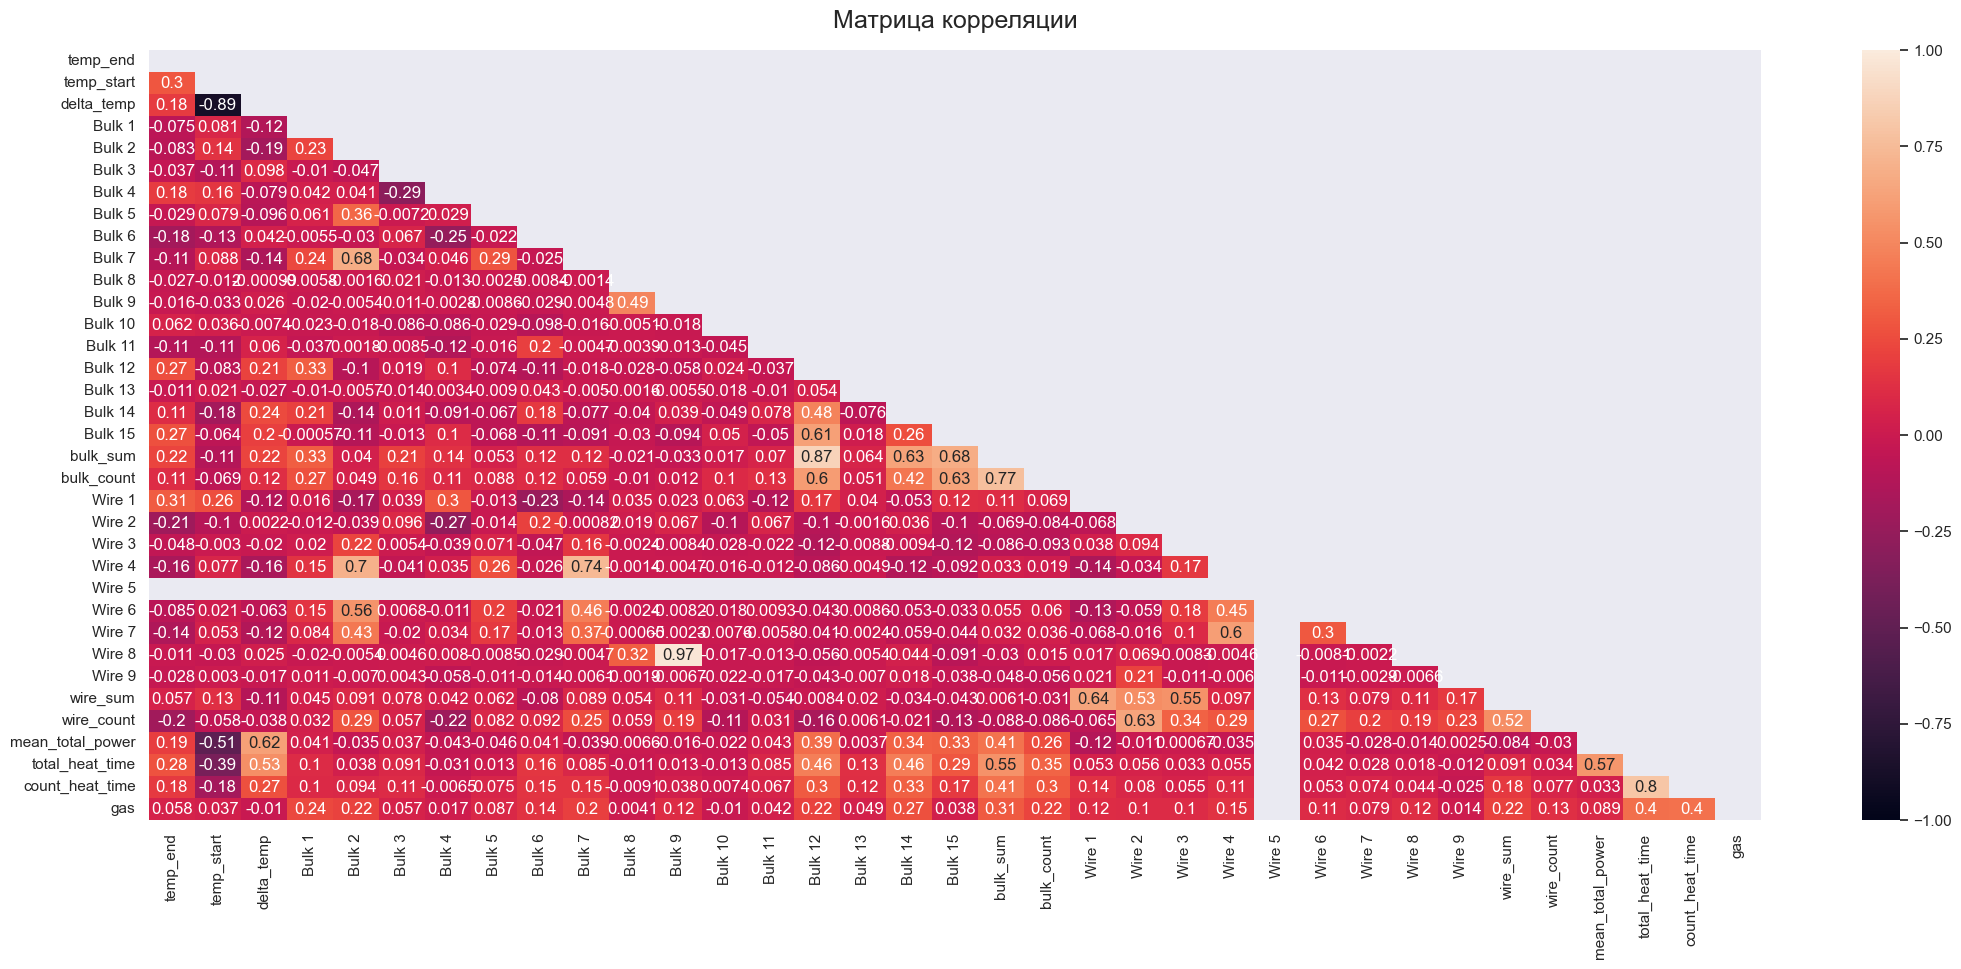

In [146]:
plt.figure(figsize=(26, 10))

mask = np.triu(np.ones_like(df_final.corr(), dtype=np.bool))

heatmap = sns.heatmap(df_final.corr(method='pearson'), mask=mask, vmin=-1, vmax=1, annot=True)

heatmap.set_title('Матрица корреляции', fontdict={'fontsize':18}, pad=16)

При построении матрицы корреляции видно, что некоторые параметры имеют сильную связь. В частности дельта по температуре и стартовая температура имеют сильную отрицательную связь ( - о.78). При формировании признаков, удалим признак `delta_temp` для исключения мультиколлинеартности.

In [147]:
df_final.corr(method='pearson')

,temp_end,temp_start,delta_temp,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Wire 6,Wire 7,Wire 8,Wire 9,wire_sum,wire_count,mean_total_power,total_heat_time,count_heat_time,gas
temp_end,1.000000,0.296543,0.179858,-0.074586,-0.083304,-0.037336,0.184766,-0.028688,-0.179698,-0.108367,...,-0.084921,-0.138632,-0.010903,-0.027800,0.056811,-0.200733,0.189591,0.275859,0.178727,0.057937
temp_start,0.296543,1.000000,-0.886110,0.080985,0.142222,-0.113109,0.163542,0.079415,-0.125151,0.088268,...,0.021239,0.053075,-0.029627,0.003013,0.130800,-0.057525,-0.508960,-0.389417,-0.179808,0.037007
delta_temp,0.179858,-0.886110,1.000000,-0.119613,-0.186920,0.098385,-0.078785,-0.095721,0.041701,-0.143509,...,-0.063089,-0.121947,0.025226,-0.016595,-0.107156,-0.038165,0.616250,0.534984,0.271943,-0.010001
Bulk 1,-0.074586,0.080985,-0.119613,1.000000,0.226139,-0.010484,0.041804,0.060692,-0.005535,0.238745,...,0.149438,0.083970,-0.019761,0.011021,0.044649,0.031754,0.040959,0.104624,0.100982,0.239301
Bulk 2,-0.083304,0.142222,-0.186920,0.226139,1.000000,-0.047449,0.041268,0.360210,-0.030318,0.679329,...,0.558831,0.431721,-0.005366,-0.006962,0.090802,0.285229,-0.034985,0.038091,0.093517,0.218610
Bulk 3,-0.037336,-0.113109,0.098385,-0.010484,-0.047449,1.000000,-0.294068,-0.007235,0.066670,-0.033920,...,0.006790,-0.019680,0.004646,0.004350,0.077814,0.057177,0.036727,0.090957,0.105074,0.057491
Bulk 4,0.184766,0.163542,-0.078785,0.041804,0.041268,-0.294068,1.000000,0.028807,-0.251213,0.046392,...,-0.011295,0.034163,0.008030,-0.058439,0.042163,-0.218204,-0.043463,-0.031176,-0.006477,0.016795
Bulk 5,-0.028688,0.079415,-0.095721,0.060692,0.360210,-0.007235,0.028807,1.000000,-0.022309,0.288249,...,0.204635,0.172099,-0.008484,-0.011008,0.061547,0.082424,-0.046143,0.012980,0.075202,0.087024
Bulk 6,-0.179698,-0.125151,0.041701,-0.005535,-0.030318,0.066670,-0.251213,-0.022309,1.000000,-0.025389,...,-0.020657,-0.012575,-0.028757,-0.013679,-0.080013,0.092164,0.041443,0.163329,0.154447,0.140733
Bulk 7,-0.108367,0.088268,-0.143509,0.238745,0.679329,-0.033920,0.046392,0.288249,-0.025389,1.000000,...,0.456040,0.372232,-0.004704,-0.006104,0.088759,0.253104,-0.039073,0.084889,0.153391,0.199410


### 3.5 Подготовка обучающей и тестовой выборок

Для постороение модели отсуствует тестовая выборка, таким образом выделим часть значений для тестовой выборки из общих предоставленных данных. Исходные данные разобъем в соотношении 80 % / 20 % обучающая и тестовые соотвественно:

In [148]:
RSdef = 12092022
df_train, df_test = train_test_split(df_final, test_size=0.20, random_state = RSdef)

In [149]:
print(df_train.shape)
print(df_test.shape)

(1831, 35)
(458, 35)


Разделим выборки на признаки и целевой параметр:

In [150]:
features_train = df_train.drop(['temp_end', 'delta_temp', 'Wire 8'], axis=1) #признаки для обучающей выборки
target_train = df_train['temp_end'] #целевой показатель для обучающей выборки

features_test = df_test.drop(['temp_end', 'delta_temp', 'Wire 8'], axis=1) #признаки для тестовой выборки
target_test = df_test['temp_end'] #целевой показатель для тестовой выборки

Выполним масштабирование признаков:

In [151]:
numeric_final= features_train.columns
scalar_final = StandardScaler()
scalar_final.fit(features_train[numeric_final])
features_train[numeric_final] =  scalar_final.transform(features_train[numeric_final])

In [152]:
features_test[numeric_final] =  scalar_final.transform(features_test[numeric_final]) #масштабирование признаков на тесте

### Выводы:

* Удалены аномальные значения в столбце реактивная мощность в датасете по электродам;
* Удалены строки (партии) с пропущенными целевым признакам в датасете по температуре, удалены партии ,где начальная температура равна конечной (утечка признака) или является единственным значением в партии, также далены строки (партии) с анамальными температурами (меньше температуры плавки стали в 1300 градусов);
* В рамках подготовки данных выполнено переименование признаков к единому стилю. Добавлены новые признаки:
  - `delta_temp` -  разница начальной и конечной температурой
  - `bulk_sum` - сумарный объем сыпучих присадок в партии
  - `bulk_count` -  число сыпучих присадок в партии
  - `wire_sum` - сумарный объем проволки в партии
  - `wire_count` -  число проволки в партии
  - `mean_total_power` - средняя полная мощность при нагреве по партии
  - `total_heat_time` - суммарное время нагрева по партии
  - `count_heat_time` - число циклов нагрева в партии

* При объединениее получили пропущенные значения, так как не все присадки есть в соотвествующих партиях. Также имеется два пропуска по объему газа, так как этих партий не было в изначальном датасете. Эти партии удалили.
 
* При построении матрицы корреляции определено, что некоторые параметры имеют сильную связь. В частности `delta_temp` и `temp_start` имеют сильную отрицательную связь ( - о.88). При формировании признаков, признак `delta_temp` исключен, во избежании мультиколлинеарности.

* Данные разделены в процентном соотношении 80/20 % на обучающую и тестовую выборки соотвественно. Произведено масштабирование признаков.

## 4. Обучение моделей

Рассмотрим применение разных моделей.

### 4.1 Обучение модели линейной регрессии

Обучим модель с учетом кросс-валидации:

In [154]:
%%time

model_lr = LinearRegression()
scores_lr = cross_val_score(
    model_lr, features_train, target_train, 
    scoring='neg_mean_absolute_error', cv=5)

final_score_lr = pd.Series(abs(scores_lr)).mean()

print(f'Средняя оценка MAE модели: {final_score_lr}') 

Средняя оценка MAE модели: 6.401845334117558
Wall time: 144 ms


In [155]:
%%time

#обучение модели
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

print('Время обучения модели:')

Время обучения модели:
Wall time: 11 ms


Визуализируем распределение важности признаков для модели:

Text(0.5, 0.95, 'Диаграмма важности признаков модели линейной регрессии')

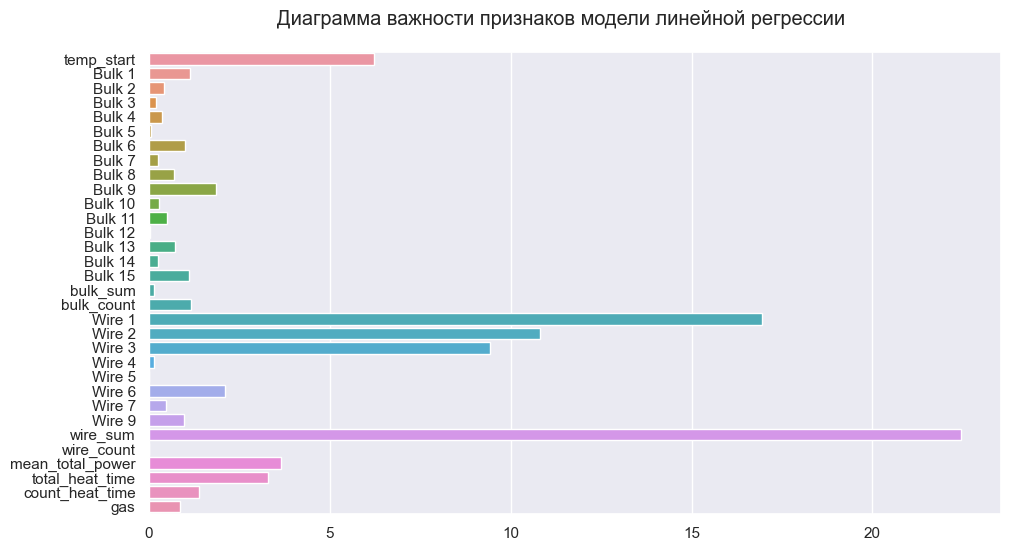

In [161]:
feature_importance_lr = abs(model_lr.coef_)
sns.barplot(x=feature_importance_lr, y=features_train.columns)
plt.suptitle('Диаграмма важности признаков модели линейной регрессии', x=0.5, y=0.95, ha='center', fontsize='large')

### 4.2 Обучение модели регрессии решающего дерева (DecisionTreeRegressor)

Для поиска оптимальных гиперпараметров модели воспользуемся GridSearchCV:

In [158]:
%%time
param_grid = [{'max_depth': [3, 5, 20, 100]}]

model_dt = DecisionTreeRegressor(random_state=RSdef)
grid_search_dt = GridSearchCV(model_dt, param_grid, cv=5,
                           scoring='neg_mean_absolute_error', 
                          n_jobs=-1,
                          verbose=1)

grid_search_dt.fit(features_train, target_train)
print(grid_search_dt.cv_results_)
print('------------------------------------------------------------------------------------------------------------------')
print(f'Лучшая модель c  MAE = {abs(grid_search_dt.best_score_)} с параметрами:{grid_search_dt.best_params_}')



Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'mean_fit_time': array([0.01224461, 0.0148005 , 0.02106285, 0.01590962]), 'std_fit_time': array([0.00198436, 0.00054908, 0.00491611, 0.00119994]), 'mean_score_time': array([0.00165591, 0.00300117, 0.00282335, 0.00119982]), 'std_score_time': array([7.65800476e-05, 1.54861944e-03, 1.46387324e-03, 3.99899550e-04]), 'param_max_depth': masked_array(data=[3, 5, 20, 100],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 3}, {'max_depth': 5}, {'max_depth': 20}, {'max_depth': 100}], 'split0_test_score': array([-7.14158624, -7.23765185, -8.10524684, -8.26702997]), 'split1_test_score': array([-7.24354795, -7.24863546, -8.28900729, -8.67759563]), 'split2_test_score': array([-7.33654324, -7.37695932, -8.94117104, -9.25409836]), 'split3_test_score': array([-6.9656437 , -7.10517251, -8.45738096, -8.55464481]), 'split4_test_score': array([-7.78347695, -7.4619177 , -8.9

In [159]:
%%time

#обучение модели
model_tree_best = DecisionTreeRegressor(random_state=RSdef, max_depth=5)
model_tree_best.fit(features_train, target_train)

print('Время обучения модели:')

Время обучения модели:
Wall time: 8 ms


Визуализируем распределение важности признаков для модели:

Text(0.5, 0.95, 'Диаграмма важности признаков модели регрессии решаюшего дерева')

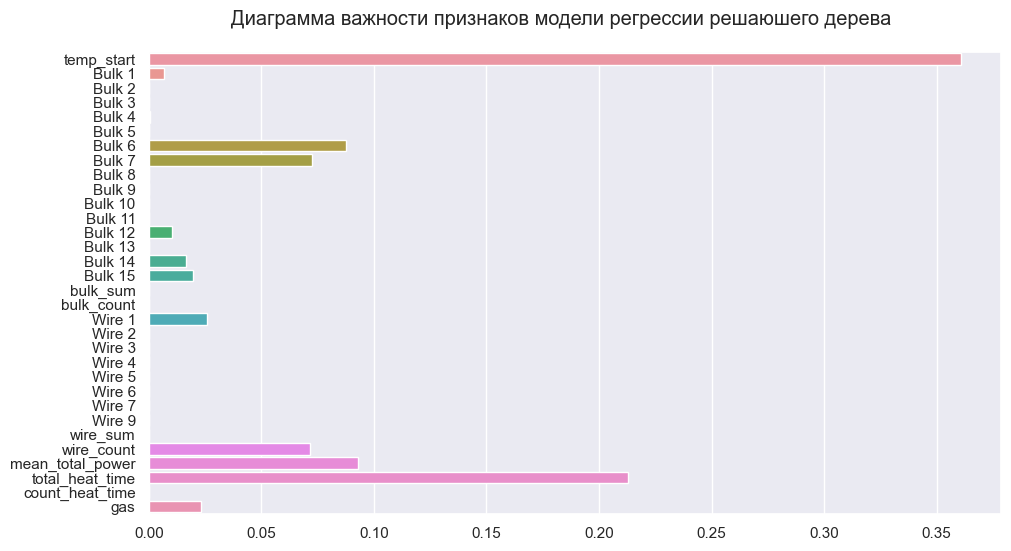

In [162]:
feature_importance_dt = model_tree_best.feature_importances_
sns.barplot(x=feature_importance_dt, y=features_train.columns)
plt.suptitle('Диаграмма важности признаков модели регрессии решаюшего дерева',
             x=0.5, y=0.95, ha='center', fontsize='large')

### 4.3 Обучение модели регрессии случайный лес (RandomForestRegressor)

In [163]:
%%time
param_grid = [{'max_depth': [2, 5, 10, 15],
              'n_estimators': [100, 250, 500, 1000]}]

model_rf = RandomForestRegressor(random_state=RSdef)
grid_search_rf = GridSearchCV(model_rf, param_grid, cv=5,
                           scoring='neg_mean_absolute_error', 
                          n_jobs=-1,
                          verbose=1)

grid_search_rf.fit(features_train, target_train)

print(grid_search_rf.cv_results_)
print('------------------------------------------------------------------------------------------------------------------')
print(f'Лучшая модель c  MAE = {abs(grid_search_rf.best_score_)} с параметрами:{grid_search_rf.best_params_}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'mean_fit_time': array([ 0.30816236,  0.77000089,  1.49608231,  2.92215257,  0.55467014,
        1.36716938,  2.72926517,  5.48742375,  0.94159269,  2.34699092,
        4.76162577, 10.04489117,  1.2325644 ,  3.11522841,  6.10401406,
        9.42541723]), 'std_fit_time': array([0.02055877, 0.03016971, 0.06921162, 0.06260194, 0.01660184,
       0.02435169, 0.0242559 , 0.07487971, 0.01999771, 0.02105272,
       0.06798437, 0.39746342, 0.02247921, 0.08884523, 0.10097765,
       0.61690496]), 'mean_score_time': array([0.00972509, 0.02147527, 0.03905315, 0.0780664 , 0.01063766,
       0.02258348, 0.04247222, 0.0897366 , 0.01203399, 0.02931547,
       0.05537038, 0.10672808, 0.01456718, 0.03792796, 0.05592632,
       0.09191318]), 'std_score_time': array([0.00092737, 0.00088226, 0.00056532, 0.00344823, 0.0002801 ,
       0.00115527, 0.00136655, 0.00648134, 0.00081376, 0.00214678,
       0.00310578, 0.00747444, 0.00037916, 0.0064135

In [164]:
%%time

#обучение модели
model_rf_best = RandomForestRegressor(random_state=RSdef, max_depth=15, n_estimators=500)
model_rf_best.fit(features_train, target_train)

print('Время обучения модели:')

Время обучения модели:
Wall time: 4.3 s


Визуализируем распределение важности признаков для модели:

Text(0.5, 0.95, 'Диаграмма важности признаков модели регрессии случайный лес')

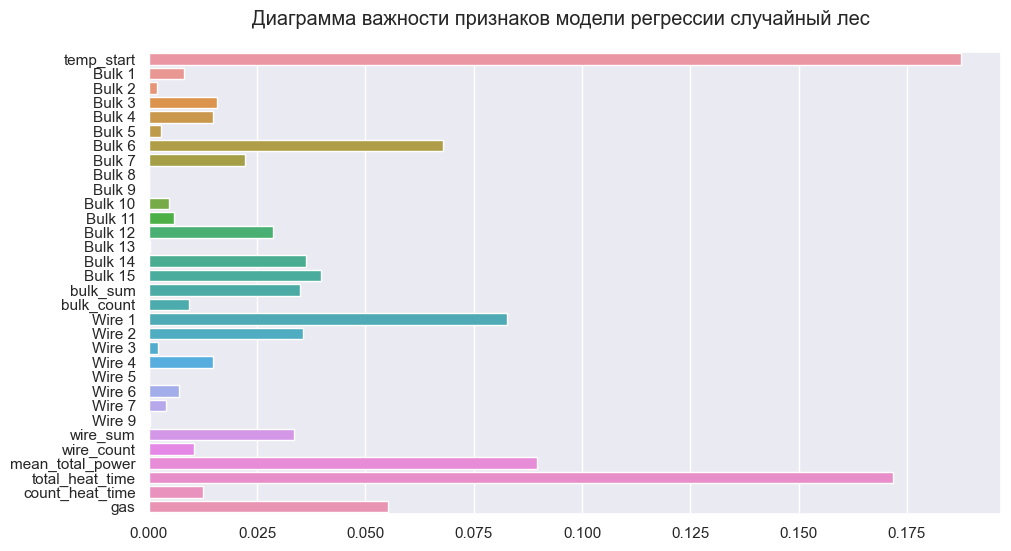

In [165]:
feature_importance_rf = model_rf_best.feature_importances_
sns.barplot(x=feature_importance_rf, y=features_train.columns)
plt.suptitle('Диаграмма важности признаков модели регрессии случайный лес', x=0.5, y=0.95, ha='center', fontsize='large')

### 4.4. Модель градиентного бустинга с  LightGBM

In [166]:
%%time
param_grid = [{'max_depth': [2, 5, 10],
              'num_leaves': [2**2, 2**5, 2**10]}]

model_lgbm = LGBMRegressor()
grid_search_lgbm = GridSearchCV(model_lgbm, param_grid, cv=5,
                           scoring='neg_mean_absolute_error', 
                          n_jobs=-1,
                          verbose=1)

grid_search_lgbm.fit(features_train, target_train)

print(grid_search_lgbm.cv_results_)
print('------------------------------------------------------------------------------------------------------------------')
print(f'Лучшая модель c  MAE = {abs(grid_search_lgbm.best_score_)} с параметрами:{grid_search_lgbm.best_params_}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'mean_fit_time': array([0.04323597, 0.04363565, 0.03291965, 0.03426638, 0.06760526,
       0.0653903 , 0.03708091, 0.1164402 , 0.14677129]), 'std_fit_time': array([0.00063173, 0.00049033, 0.00813099, 0.0016218 , 0.00585841,
       0.00395127, 0.00275854, 0.00678695, 0.00411368]), 'mean_score_time': array([0.00259981, 0.00279965, 0.00220113, 0.00318484, 0.00335989,
       0.00344815, 0.00365152, 0.00407324, 0.00319653]), 'std_score_time': array([0.00049045, 0.00040026, 0.00039957, 0.00144008, 0.0003933 ,
       0.00063382, 0.00058455, 0.00071294, 0.00040519]), 'param_max_depth': masked_array(data=[2, 2, 2, 5, 5, 5, 10, 10, 10],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_num_leaves': masked_array(data=[4, 32, 1024, 4, 32, 1024, 4, 32, 1024],
             mask=[False, False, False, False, False, False, False, False

In [167]:
%%time

#обучение модели
model_lgbm_best = LGBMRegressor(max_depth=5, num_leaves=4)
model_lgbm_best.fit(features_train, target_train)

print('Время обучения модели:')

Время обучения модели:
Wall time: 19.5 ms


Визуализируем распределение важности признаков для модели:

Text(0.5, 0.95, 'Диаграмма важности признаков модели градиентного бустинга с LightGBM')

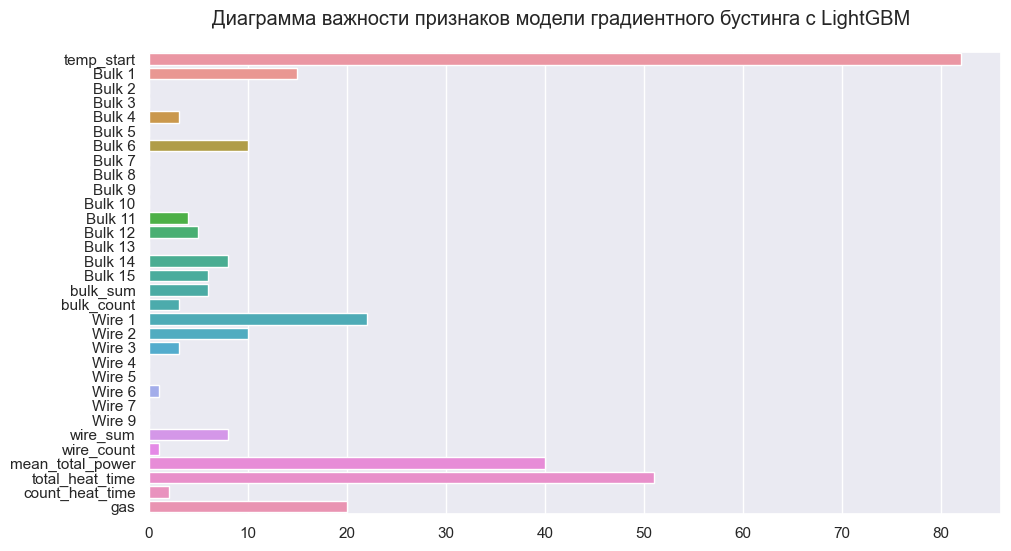

In [168]:
feature_importance_lgbm = model_lgbm_best.feature_importances_
sns.barplot(x=feature_importance_lgbm, y=features_train.columns)
plt.suptitle('Диаграмма важности признаков модели градиентного бустинга с LightGBM', 
             x=0.5, y=0.95, ha='center', fontsize='large')

### 4.5. Dummy-модель

Для проверки адекватности построенных моделей, проверим результаты для стационарной Dummy-модели:

In [169]:
model_dummy = DummyRegressor(strategy='mean')
scores_dummy = cross_val_score(
    model_dummy, features_train, target_train, 
    scoring='neg_mean_absolute_error', cv=5)

final_score_dummy = pd.Series(abs(scores_dummy)).mean()

print(f'Средняя оценка MAE модели: {final_score_dummy}') 

Средняя оценка MAE модели: 8.006026416934137


### 4.6 CatBoost

Дополнительно рассмотрим модель CatBoost:

In [170]:
%%time
param_grid = [{'depth': [2, 4, 6],
              'iterations': [100, 200, 400]}]

model_cb = cb.CatBoostRegressor()
grid_search_cb = GridSearchCV(model_cb, param_grid, cv=5,
                           scoring='neg_mean_absolute_error', 
                          n_jobs=-1,
                          verbose=1)

grid_search_cb.fit(features_train, target_train)

print(grid_search_cb.cv_results_)
print('------------------------------------------------------------------------------------------------------------------')
print(f'Лучшая модель c  MAE = {abs(grid_search_cb.best_score_)} с параметрами:{grid_search_cb.best_params_}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Learning rate set to 0.094888
0:	learn: 10.9219608	total: 164ms	remaining: 1m 5s
1:	learn: 10.6991196	total: 165ms	remaining: 32.9s
2:	learn: 10.5794537	total: 166ms	remaining: 22s
3:	learn: 10.3862798	total: 167ms	remaining: 16.5s
4:	learn: 10.2300864	total: 167ms	remaining: 13.2s
5:	learn: 10.1001553	total: 168ms	remaining: 11s
6:	learn: 9.9927038	total: 169ms	remaining: 9.49s
7:	learn: 9.8773310	total: 170ms	remaining: 8.31s
8:	learn: 9.7654973	total: 170ms	remaining: 7.4s
9:	learn: 9.6767141	total: 171ms	remaining: 6.68s
10:	learn: 9.6066682	total: 172ms	remaining: 6.08s
11:	learn: 9.4855437	total: 173ms	remaining: 5.58s
12:	learn: 9.3771378	total: 173ms	remaining: 5.16s
13:	learn: 9.2772096	total: 174ms	remaining: 4.8s
14:	learn: 9.1859521	total: 175ms	remaining: 4.49s
15:	learn: 9.1051617	total: 176ms	remaining: 4.21s
16:	learn: 9.0335264	total: 176ms	remaining: 3.97s
17:	learn: 8.9742172	total: 177ms	remaining: 3.76s
18

303:	learn: 5.8407898	total: 395ms	remaining: 125ms
304:	learn: 5.8355826	total: 396ms	remaining: 123ms
305:	learn: 5.8337280	total: 397ms	remaining: 122ms
306:	learn: 5.8300805	total: 397ms	remaining: 120ms
307:	learn: 5.8272116	total: 398ms	remaining: 119ms
308:	learn: 5.8161682	total: 399ms	remaining: 118ms
309:	learn: 5.8100215	total: 400ms	remaining: 116ms
310:	learn: 5.8002478	total: 401ms	remaining: 115ms
311:	learn: 5.7998923	total: 402ms	remaining: 113ms
312:	learn: 5.7976142	total: 402ms	remaining: 112ms
313:	learn: 5.7959918	total: 403ms	remaining: 110ms
314:	learn: 5.7887045	total: 404ms	remaining: 109ms
315:	learn: 5.7810605	total: 405ms	remaining: 108ms
316:	learn: 5.7749204	total: 406ms	remaining: 106ms
317:	learn: 5.7676260	total: 406ms	remaining: 105ms
318:	learn: 5.7607325	total: 407ms	remaining: 103ms
319:	learn: 5.7547548	total: 408ms	remaining: 102ms
320:	learn: 5.7487859	total: 409ms	remaining: 101ms
321:	learn: 5.7467682	total: 410ms	remaining: 99.2ms
322:	learn:

In [171]:
%%time

#обучение модели
model_cb_best = cb.CatBoostRegressor(depth=4, iterations=400)
model_cb_best.fit(features_train, target_train)

print('Время обучения модели:')

Learning rate set to 0.094888
0:	learn: 10.9219608	total: 32.3ms	remaining: 12.9s
1:	learn: 10.6991196	total: 33.2ms	remaining: 6.62s
2:	learn: 10.5794537	total: 34.2ms	remaining: 4.53s
3:	learn: 10.3862798	total: 34.9ms	remaining: 3.46s
4:	learn: 10.2300864	total: 35.7ms	remaining: 2.82s
5:	learn: 10.1001553	total: 36.6ms	remaining: 2.4s
6:	learn: 9.9927038	total: 37.4ms	remaining: 2.1s
7:	learn: 9.8773310	total: 38.1ms	remaining: 1.87s
8:	learn: 9.7654973	total: 38.9ms	remaining: 1.69s
9:	learn: 9.6767141	total: 39.7ms	remaining: 1.55s
10:	learn: 9.6066682	total: 40.5ms	remaining: 1.43s
11:	learn: 9.4855437	total: 41.2ms	remaining: 1.33s
12:	learn: 9.3771378	total: 42ms	remaining: 1.25s
13:	learn: 9.2772096	total: 42.8ms	remaining: 1.18s
14:	learn: 9.1859521	total: 43.5ms	remaining: 1.12s
15:	learn: 9.1051617	total: 44.3ms	remaining: 1.06s
16:	learn: 9.0335264	total: 45.1ms	remaining: 1.01s
17:	learn: 8.9742172	total: 46ms	remaining: 976ms
18:	learn: 8.9097989	total: 46.9ms	remaining

230:	learn: 6.2173000	total: 190ms	remaining: 139ms
231:	learn: 6.2069322	total: 190ms	remaining: 138ms
232:	learn: 6.2021292	total: 191ms	remaining: 137ms
233:	learn: 6.1966624	total: 192ms	remaining: 136ms
234:	learn: 6.1916507	total: 193ms	remaining: 135ms
235:	learn: 6.1856814	total: 193ms	remaining: 134ms
236:	learn: 6.1738492	total: 194ms	remaining: 134ms
237:	learn: 6.1683534	total: 195ms	remaining: 133ms
238:	learn: 6.1677920	total: 195ms	remaining: 132ms
239:	learn: 6.1612899	total: 196ms	remaining: 131ms
240:	learn: 6.1577024	total: 197ms	remaining: 130ms
241:	learn: 6.1552851	total: 197ms	remaining: 129ms
242:	learn: 6.1530539	total: 198ms	remaining: 128ms
243:	learn: 6.1460606	total: 199ms	remaining: 127ms
244:	learn: 6.1372513	total: 199ms	remaining: 126ms
245:	learn: 6.1359341	total: 200ms	remaining: 125ms
246:	learn: 6.1263620	total: 201ms	remaining: 124ms
247:	learn: 6.1221659	total: 202ms	remaining: 124ms
248:	learn: 6.1214019	total: 202ms	remaining: 123ms
249:	learn: 

Text(0.5, 0.95, 'Диаграмма важности признаков модели CatBoost')

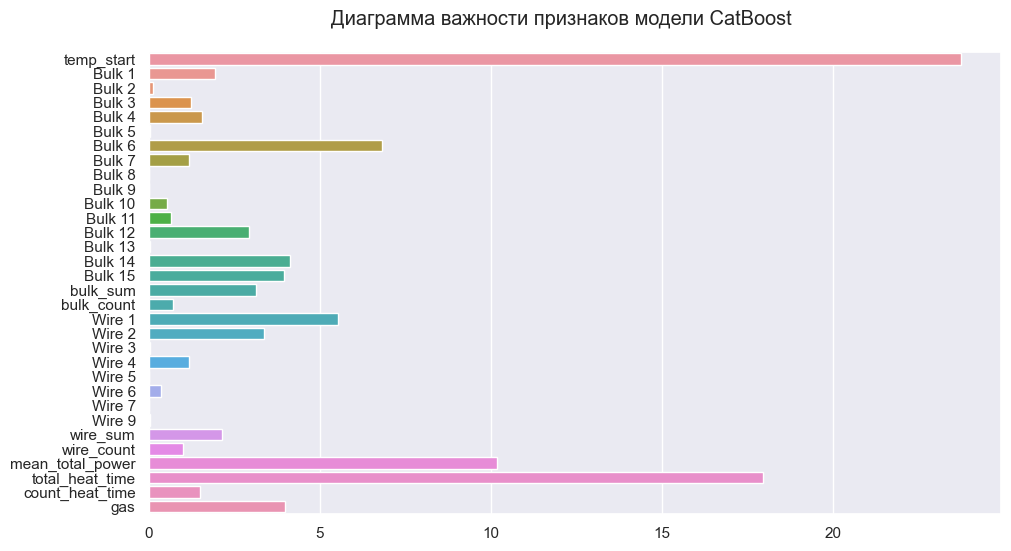

In [172]:
feature_importance_cb = model_cb_best.feature_importances_
#px.bar(x=feature_importance_cb, y=features_train.columns)

sns.barplot(x=feature_importance_cb, y=features_train.columns)
plt.suptitle('Диаграмма важности признаков модели CatBoost', x=0.5, y=0.95, ha='center', fontsize='large')

### 4.7 Анализ моделей

Сведем результаты на обучении лучших моделей в таблицу, а также визуализируем важность признаков для разных моделей:

Text(0.5, 0.95, 'Сравнение важности признаков для разных моделей')

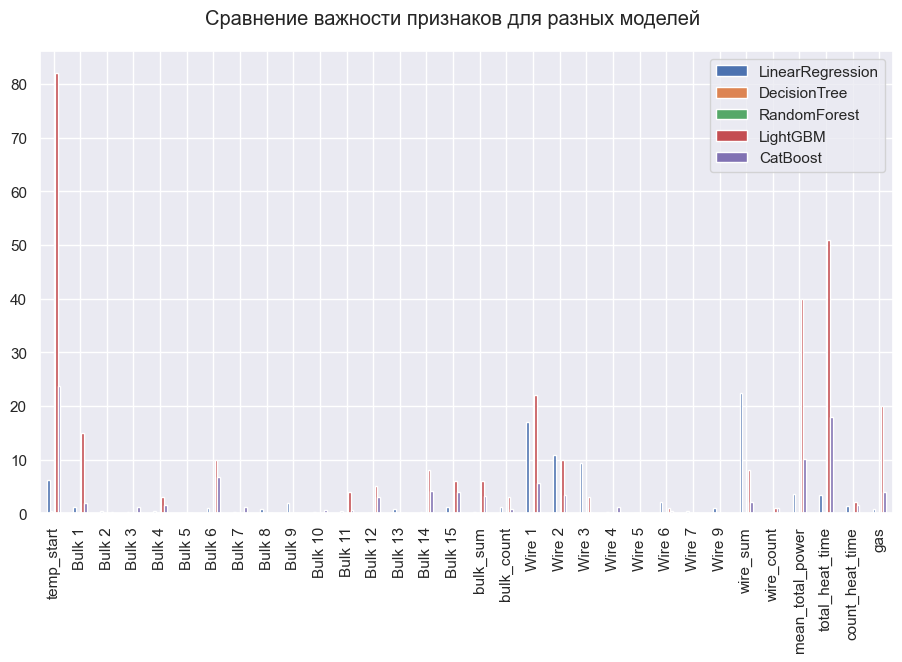

In [257]:
d = {'LinearRegression': feature_importance_lr,
     'DecisionTree': feature_importance_dt,
     'RandomForest': feature_importance_rf,
     'LightGBM': feature_importance_lgbm,
     'CatBoost': feature_importance_cb}

pd.DataFrame(data=d, index=features_train.columns).plot.bar()
plt.suptitle('Сравнение важности признаков для разных моделей', x=0.5, y=0.95, ha='center', fontsize='large')

In [177]:
results = {
    'MAE на обучении': [final_score_lr, 
                        abs(grid_search_dt.best_score_), 
                        abs(grid_search_rf.best_score_), 
                        abs(grid_search_lgbm.best_score_),
                        abs(grid_search_cb.best_score_), 
                        final_score_dummy]
}

train_results = pd.DataFrame(data=results, index=['LinearRegression',
                                                  'DecisionTree',
                                                  'RandomForest',
                                                  'LGBM', 
                                                  'CatBoost', 
                                                  'Dummy'])

display(train_results)

,MAE на обучении
LinearRegression,6.401845
DecisionTree,7.286067
RandomForest,6.144013
LGBM,6.125985
CatBoost,5.996422
Dummy,8.006026


При анализе важности признаков видно, что для моделей основными важными признаками являются суммарный объем проволочной присадки, число этой проволочной присадки, стартовая температура плавки, мощность и время нагрева.

Лучшим значением MAE на обучающей выборки обладает модель регрессии CatBoost со значеним 5.99 и гиперпараметрами 'depth' = 4, 'iterations' = 400

## 5. Тестирование лучшей модели

Выполним тестирование лучшей выбранной модели (модель регрессии CatBoost):

In [178]:
%%time

#обучение модели
model_cb_best = cb.CatBoostRegressor(depth=4, iterations=400)
model_cb_best.fit(features_train, target_train)

print('Время обучения модели:')

Learning rate set to 0.094888
0:	learn: 10.9219608	total: 12.3ms	remaining: 4.89s
1:	learn: 10.6991196	total: 13.5ms	remaining: 2.69s
2:	learn: 10.5794537	total: 14.4ms	remaining: 1.91s
3:	learn: 10.3862798	total: 15.2ms	remaining: 1.5s
4:	learn: 10.2300864	total: 16ms	remaining: 1.26s
5:	learn: 10.1001553	total: 16.7ms	remaining: 1.09s
6:	learn: 9.9927038	total: 17.5ms	remaining: 981ms
7:	learn: 9.8773310	total: 18.1ms	remaining: 889ms
8:	learn: 9.7654973	total: 18.9ms	remaining: 823ms
9:	learn: 9.6767141	total: 19.7ms	remaining: 770ms
10:	learn: 9.6066682	total: 20.5ms	remaining: 724ms
11:	learn: 9.4855437	total: 21.2ms	remaining: 685ms
12:	learn: 9.3771378	total: 21.9ms	remaining: 651ms
13:	learn: 9.2772096	total: 22.6ms	remaining: 623ms
14:	learn: 9.1859521	total: 23.3ms	remaining: 598ms
15:	learn: 9.1051617	total: 24ms	remaining: 576ms
16:	learn: 9.0335264	total: 24.7ms	remaining: 557ms
17:	learn: 8.9742172	total: 25.5ms	remaining: 542ms
18:	learn: 8.9097989	total: 26.3ms	remainin

260:	learn: 6.0627159	total: 199ms	remaining: 106ms
261:	learn: 6.0597496	total: 200ms	remaining: 105ms
262:	learn: 6.0553002	total: 201ms	remaining: 105ms
263:	learn: 6.0470536	total: 202ms	remaining: 104ms
264:	learn: 6.0407929	total: 202ms	remaining: 103ms
265:	learn: 6.0384010	total: 203ms	remaining: 102ms
266:	learn: 6.0367564	total: 204ms	remaining: 102ms
267:	learn: 6.0304555	total: 205ms	remaining: 101ms
268:	learn: 6.0262734	total: 205ms	remaining: 100ms
269:	learn: 6.0240430	total: 206ms	remaining: 99.3ms
270:	learn: 6.0235739	total: 207ms	remaining: 98.5ms
271:	learn: 6.0144141	total: 208ms	remaining: 97.7ms
272:	learn: 6.0087072	total: 208ms	remaining: 96.9ms
273:	learn: 6.0055275	total: 209ms	remaining: 96.1ms
274:	learn: 6.0022562	total: 210ms	remaining: 95.3ms
275:	learn: 5.9952314	total: 210ms	remaining: 94.6ms
276:	learn: 5.9890424	total: 211ms	remaining: 93.8ms
277:	learn: 5.9869436	total: 212ms	remaining: 93ms
278:	learn: 5.9811902	total: 213ms	remaining: 92.2ms
279:

In [179]:
%%time

#предсказание модели
prediction_cb_best = model_cb_best.predict(features_test)

mae_cb_best = mean_absolute_error(target_test, prediction_cb_best)

print(f'MAE модели на тестовой выборке:{mae_cb_best}')
print('Скорость предсказания модели:')

MAE модели на тестовой выборке:5.907456564933929
Скорость предсказания модели:
Wall time: 4.48 ms


MAE на тестовой выборке составляет 5.907.

## 6. Отчет о проделанной работе.

### 6.1 Задача

Металлургический комбинат планирует оптимизировать затраты(снизить издержки), путем уменьшения энергопотребления предприятия. С учетом того, что плавка металла является самым энергоемким процессом на предприятии, стоит задача по прогнозированию оптимальной температуры плавки металла, как одно из мероприятий по регулированию энергопотребления. 

Таким образом оснвная задача проекта это подготовка модели прогнозирования оптимальной температуры плавки стали (решение задачи регрессии) с требуемым качеством (метрикой) MAE не менее 7.6, целевым MAE менее 6.

В рамках исходных данных предоставлено 7 наборов данных собранных из разных источников:

- данные об электродах;
- данные о подаче сыпучих материалов (объём);
- данные о подаче сыпучих материалов (время);
- данные о продувке сплава газом;
- результаты измерения температуры;
- данные о проволочных материалах (объём);
- данные о проволочных материалах (время).


Целевым параметром для обучения модели является последний замер температуры по партии из набора данных по результатам измерения температуры.


### 6.2 Описание технологического процесса рассматриваемого этапа обработки

Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами, установленнм в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

### 6.3 План работы

 - Обзор, проверка и исследовательский анализ данных;
 - Педобработка данных и подготовка данных;
 - Обучение различных моделей;
 - Выбор лучшей модели и тестирование;
 - Анализ и вывод по полученным результатам.

### 6.4 Решение задачи

В первую очередь было необходимо выполнить обзор и проверку полученных данных. На данном этапе в ряде датасетов были обнаружены пропущенные значения и несколько аномалий, а именно:


* Аномальное  отрицательное значение по реактивной мощности, учитывая, что значения Активной мощности лежат в допустимых пределах строка была удалена из датасета о времени и мощности нагрева, 
* Аномальные значения температуры в датасете о результатах измерения температуры (значения ниже физических / справочных значения температуры плавления стали (1300 градусов). Данные по партиям с аномальными значениями были удалены.
* Пропуски по целевому признаку в датасете о результатах измерения температуры (~18 % данных по столбцу), данные по партии также были удалены.
* Значения колличества и номеров партий отличаются в заивисмоти от датасета, что необходимо  было устарено на этапе предобработки данных
* Пропуски значений в датасетах об объемах присадок, свзанные с отсуствием подачи той или иной присадки в рассматриваемый интервал времени (данные заменены на 0).


На  этапе исследовательского анализа было отмечено, что:

* Медина значения Активной мощности составляет 0.55 МВт, значчение Реактивно мощности составляет 0.41 МВар. 
* Для ряда партий суммарное время нагрева более 2000 с.
* Для большинства партий требуется 3 - 6 циклов для достижения целевого хим. состава и температуры плавки. 
* Среднее время цикла нагрева 172 секунды (~3 минуты), при средней активной мощности 0.67 МВт.
* Распределение температуры носит нормальный характер с мединой в значении 1591 градус Цельсия.
* Наибольший объем супучей присадки, используемой в процессе, является присадка типа `Bulk12`(638154) , далее `Bulk 14` и `Bulk 15`, наименьший объем у присадки `Bulk 8`(49). Несмотря на то, что присадка `Bulk 12` имеет больший объем, но наиболее часто используемой присадкой является `Bulk 14` (2806 раза), а потом `Bulk 12` и `Bulk 15`. Реже всех используется присадка `Bulk 8`(1 раз). 
* Распределение суммарного объема присадок в партии носит нормальный характер с явным пиком 500 - 600, и локальным пиковым значением в интервале 50 - 150.
* Наибольший объем проволки, используемый в процессе, принадлежит типу `Wire 1` (308236.83), далее `Wire 2` и `Wire 3`. Наименьший объем у проволки типа `Wire 5`(15.1). Наиболее часто использумая проволка типа `Wire 1` (3055 раз), за ней идут `Wire 2`  и `Wire 6`. Меньше всех используется `Wire 5`(1 раз). 
* Распределение суммарного объема проволки в партии носит нормальный характер с явным пиком 100 - 110.

Далее с целью повышения в перспективе качества модели была осуществлена предобработка данных с формированием новых признаков, таких как:
 
  - `delta_temp` -  разница начальной и конечной температурой
  - `bulk_sum` - сумарный объем сыпучих присадок в партии
  - `bulk_count` -  число сыпучих присадок в партии
  - `wire_sum` - сумарный объем проволки в партии
  - `wire_count` -  число проволки в партии
  - `mean_total_power` - средняя полная мощность при нагреве по партии
  - `total_heat_time` - суммарное время нагрева по партии
  - `count_heat_time` - число циклов нагрева в партии


При объединениее получили пропущенные значения, так как не все присадки есть в соотвествующих партиях. Партии удалили. Также имеется два пропуска по объему газа, так как этих партий не было в изначальном датасете. Эти партии тоже удалили.
 
* При построении матрицы корреляции определено, что некоторые параметры имеют сильную связь. В частности `delta_temp` и `temp_start` имеют сильную отрицательную связь ( - о.88), что логично, поэтому данный признак был исключен. Также при разработке. При формировании признаков, признак `delta_temp` исключен, во избежании мультиколлинеарности. Также обнаружена сильная положительная связь между признаком `Wire 8` с `Bulk 9` (0.93), также исключен, во избежании мультиколлинеарности.

Матрица корреляции приведена ниже:

Text(0.5, 1.0, 'Матрица корреляции')

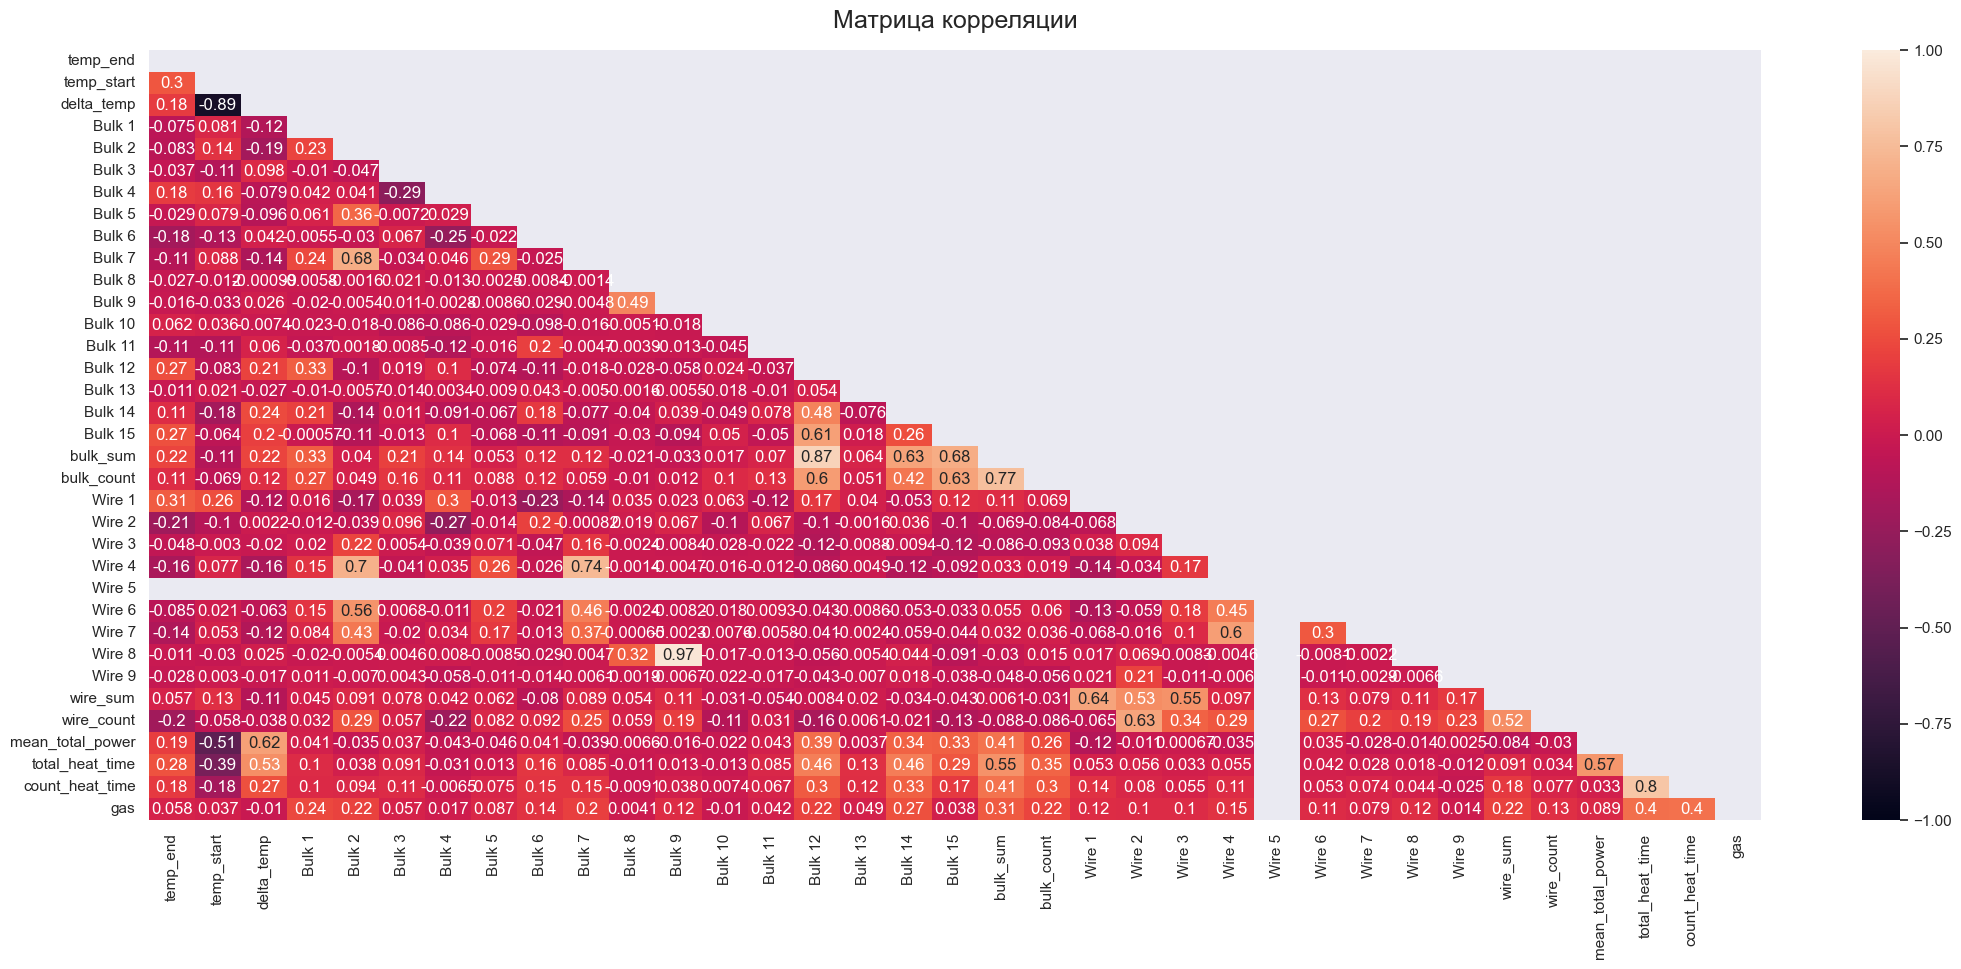

In [180]:
plt.figure(figsize=(26, 10))

mask = np.triu(np.ones_like(df_final.corr(), dtype=np.bool))

heatmap = sns.heatmap(df_final.corr(method='pearson'), mask=mask, vmin=-1, vmax=1, annot=True)

heatmap.set_title('Матрица корреляции', fontdict={'fontsize':18}, pad=16)

Перед началом обучения различных моделей данные были разделены в процентном соотношении 80/20 % на обучающую и тестовую выборки соотвественно. Произведено масштабирование признаков.

В качестве набора моделей определены были следующие типы: 
* Линейная регрессия
* Модель регрессии Решающего дерева(Decision Regressor)
* Модель регрессии Случайный лес (RandomForestRegressor)
* Модель бустинга LightGBM
* Модель CatBooost
* Dummy-модель для проверки адеватности результата решения

### 6.5 Результаты решения и факторы выбранной модели

На этапе обучения и поиска лучших параметров указанных выше типов моделей на обучающей выборке получили следующие результаты: 

In [181]:
results = {
    'MAE на обучении': [final_score_lr, 
                        abs(grid_search_dt.best_score_), 
                        abs(grid_search_rf.best_score_), 
                        abs(grid_search_lgbm.best_score_),
                        abs(grid_search_cb.best_score_), 
                        final_score_dummy]
}
train_results = pd.DataFrame(data=results, index=['LinearRegression',
                                                  'DecisionTree',
                                                  'RandomForest',
                                                  'LGBM', 
                                                  'CatBoost', 
                                                  'Dummy'])
display(train_results)

,MAE на обучении
LinearRegression,6.401845
DecisionTree,7.286067
RandomForest,6.144013
LGBM,6.125985
CatBoost,5.996422
Dummy,8.006026


По результатам видно, что лучшей метрикой (MAE) обладает модель бустинга CarBoost  с гиперпараметрами depth = 4 и iterations = 400 и равняется 5.99, что уже соотвествует целевому значению. Далее по качеству следуют модель бустинга LGBM и модель регрессии Случайного леса с 6.12 и 6.14 MAE соотвественно. Dummy-модель показала MAE = 8, что говорит об эффективности рассмотрнеия выбранных моделей. 


На диаграмме ниже, продемонстрированы важности признаков для различных моделей:

Text(0.5, 0.95, 'Сравнение важности признаков для разных моделей')

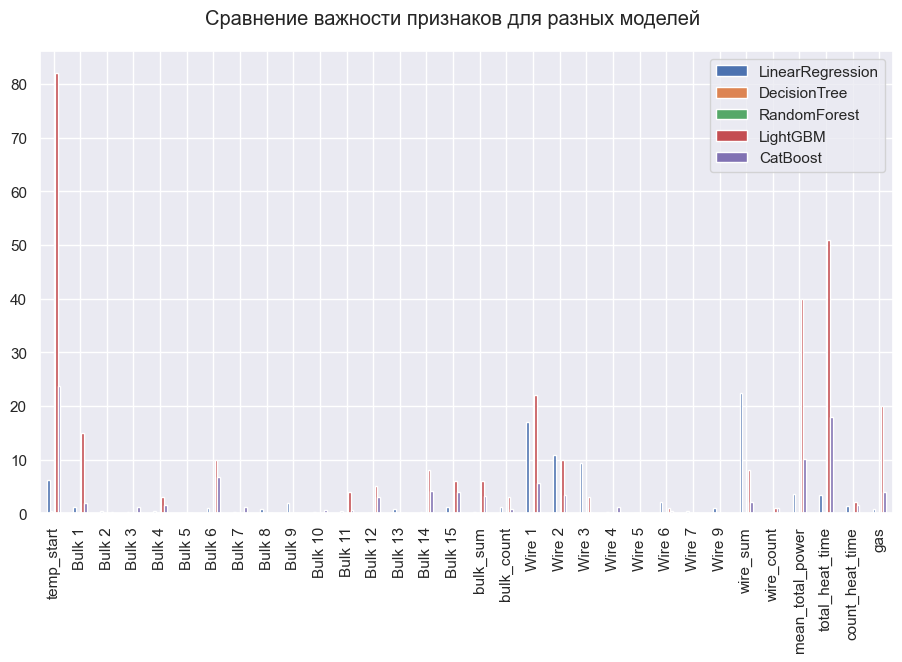

In [258]:
pd.DataFrame(data=d, index=features_train.columns).plot.bar()
plt.suptitle('Сравнение важности признаков для разных моделей', x=0.5, y=0.95, ha='center', fontsize='large')

По распределению важности признаков для разных моделей видно, что практически для всех типов моделей подавляющим приоритетом обладает признак начальной температуры, средней мощности нагрева и суммарного времени нагрева. Также важен объем продувки газа в совокупности с использованием нескольки типов присадок которые коррелируют с объемом их использования в партиях за рассматриваемый период времени.

Как было отмечено ранее, лучшими показателями обладает модель CatBoost с глубиной 4 и максимальным количеством деревьев = 400. Данная модель была принята за основну.

С учетом этих параметров было произведено тестирование на выделенной тестовой выборке. MAE составло 5.9, что выше значения на обучающей выборке, что также говорит об отсуствия переобучения модели и соотвествует целевой метрике по качеству.

### 6.6 Анализ результатов (ключевые шаги) и выводы

В ходе выполнения работы был произведен обзор данных, их проверка и исследовательский анализ, сформирован план работы. Выявленые аномалии данных и пропуски,  были устранены на этапе предобработки данных. В рамках подготовки данных сформирован итоговый датасет с выверенными данными партий и созданными признаками для улучшения качества модели. Данные этапы выполнены в соотвествии с поставленным планом, ключевым шагом в котором являлось выявление именно аномалий данных (а не идентификация выбросов в качестве аномалий) и подготовка новых признаков для обучения моделей (средняя мощность, время нагрева оказались в числе наиболее важных признаков для модели обучения).  
По результатам обучения моделей опеределан модель CatBoost c гиперпараметрами depth = 4 и iterations = 400 и MAE = 5.99.

На тестовой выборке эта модель также показала высокое значение метрики MAE = 5.9.

На основании вышесказанного, рекомендуется рассмотреть применение модели CatBoost c гиперпараметрами depth = 4 и iterations = 400 в качестве основной с целью прогнозирования оптимальной температуры плавки стали.